In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from utils import constants as cnst, u_darrays as uda
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
import salem
import cartopy
import xarray as xr
import glob
import ipdb

# Some defaults
cmap = plt.get_cmap('RdBu_r')
sns.set_context('talk')
sns.set_style('ticks')

ModuleNotFoundError: No module named 'utils'

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [16]:
#mcs = cnst.GRIDSAT_PERU + 'aggs/gridsat_WA_-40_allClouds_monthly.nc'
mcs = cnst.GRIDSAT_PERU + 'aggs/gridsat_WA_count_-50_allClouds_monthly.nc'
chirps = '/media/ck/Elements/global/CHIRPS/chirps-v2.0.monthly.nc'
ndvi = '/media/ck/Elements/global/NDVI_monthly/*.nc'
fpath = cnst.network_data + 'figs/HUARAZ/'


In [190]:

altiplano = [-74, -61, -18, -14]#[-74.5, -65, -20, -13] # altiplano
peru = [-79, -74, -12, -7] #tropics
tbox = [-60,-50,-12,-5]

In [191]:
def load(isbuffer, mcs,chirps):
    fname = '/home/ck/DIR/cornkle/data/HUARAZ/shapes/riosan_sel_one.shp'
    topo = xr.open_dataarray(cnst.TOPO_1MIN).sel(lon=slice(isbuffer[0], isbuffer[1]), lat=slice(isbuffer[2], isbuffer[3]))
    da3 = xr.open_dataarray(mcs).sel(lon=slice(isbuffer[0], isbuffer[1]), lat=slice(isbuffer[2], isbuffer[3]))
    ca = xr.open_dataarray(chirps).sel(longitude=slice(isbuffer[0], isbuffer[1]), latitude=slice(isbuffer[2], isbuffer[3]))
#     ndvi = xr.open_mfdataset(ndvi_f)
#     ndvi = uda.flip_lat(ndvi)
#     ndvi = ndvi['CMG 0.05 Deg Monthly NDVI'].sel(lon=slice(isbuffer[0], isbuffer[1]), lat=slice(isbuffer[2], isbuffer[3]))
    
    topo_on_da3 = da3.salem.lookup_transform(topo)
    da3 = da3.where(topo_on_da3>3000)

    topo_on_ca = ca.salem.lookup_transform(topo)
    ca = ca.where(topo_on_ca>3000)
    
    return da3, ca

In [192]:
alti_cloud, alti_rain = load(altiplano, mcs, chirps)

In [193]:
#peru_cloud, peru_rain , peru_ndvi= load(peru, mcs, chirps,ndvi)

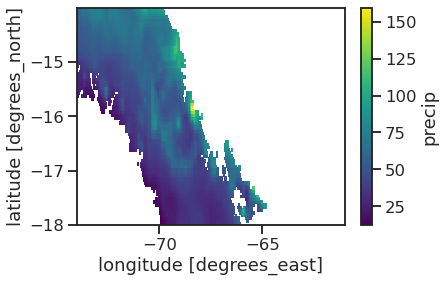

In [276]:
alti_rain.mean('time').plot()

In [195]:
da3 = alti_cloud.mean(['lat', 'lon'])*100
ca = alti_rain.mean(['latitude', 'longitude'])
#ndvi = alti_ndvi.where(alti_ndvi>=0).mean(['lat', 'lon'])

In [196]:
def leap_year(year, calendar='standard'):
    """Determine if year is a leap year"""
    leap = False
    if ((calendar in ['standard', 'gregorian',
        'proleptic_gregorian', 'julian']) and
        (year % 4 == 0)):
        leap = True
        if ((calendar == 'proleptic_gregorian') and
            (year % 100 == 0) and
            (year % 400 != 0)):
            leap = False
        elif ((calendar in ['standard', 'gregorian']) and
                 (year % 100 == 0) and (year % 400 != 0) and
                 (year < 1583)):
            leap = False
    return leap

In [197]:
dpm = {'noleap': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '365_day': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'standard': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'proleptic_gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'all_leap': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '366_day': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '360_day': [0, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]}
def get_dpm(time, calendar='standard'):
    """
    return a array of days per month corresponding to the months provided in `months`
    """
    month_length = np.zeros(len(time), dtype=np.int)

    cal_days = dpm[calendar]

    for i, (month, year) in enumerate(zip(time.month, time.year)):
        month_length[i] = cal_days[month]
        if leap_year(year, calendar=calendar):
            month_length[i] += 1
    return month_length

In [198]:
# Wrap it into a simple function
def season_mean(ds, calendar='standard'):
    # Make a DataArray of season/year groups
#     year_season = xr.DataArray(ds.time.to_index().to_period(freq='Q-NOV').to_timestamp(how='E'),
#                                coords=[ds.time], name='year_season')

    month_length = xr.DataArray(get_dpm(ds.time.to_index(), calendar='standard'),coords=[ds.time],name='month_length')
    result = ((ds * month_length).resample(time='QS-JAN').sum() /  month_length.where(ds.notnull()).resample(time='QS-JAN').sum())  #QS-DEC

    # Calculate the weighted average
    #ipdb.set_trace()
    return result[result['time.month']==1]


In [199]:
# Wrap it into a simple function
def season_mean_ndvi(ds, calendar='standard'):
    # Make a DataArray of season/year groups
#     year_season = xr.DataArray(ds.time.to_index().to_period(freq='Q-NOV').to_timestamp(how='E'),
#                                coords=[ds.time], name='year_season')

    month_length = xr.DataArray(get_dpm(ds.time.to_index(), calendar='standard'),coords=[ds.time],name='month_length')
    result = ((ds * month_length).resample(time='QS-JAN').sum() /  month_length.where(ds.notnull()).resample(time='QS-JAN').sum())  #QS-DEC

    # Calculate the weighted average
    #ipdb.set_trace()
    return result[result['time.month']==1]

In [200]:
gts = season_mean(da3)

In [201]:
cts = season_mean(ca)

In [202]:
nts = season_mean_ndvi(ndvi)

AttributeError: 'str' object has no attribute 'time'

In [275]:
ca

<xarray.DataArray 'precip' (time: 460)>
array([147.1497   , 155.28198  ,  90.85153  ,  43.251366 ,  11.285051 ,
         4.538951 ,   5.9052777,  14.982651 ,  31.651167 ,  39.296494 ,
        46.102695 ,  99.7454   , 133.49612  ,  78.67546  ,  99.32155  ,
        35.28047  ,   9.815572 ,   5.216595 ,   5.640777 ,  10.197254 ,
        30.681095 ,  41.34754  ,  70.21662  ,  40.511875 ,  63.062103 ,
        59.2727   ,  47.241436 ,  29.380768 ,  13.13846  ,   4.7779236,
         6.0571966,   9.592435 ,  26.545612 ,  16.573565 ,  23.147142 ,
        70.77838  , 198.64325  , 188.17567  , 144.75471  ,  31.487598 ,
        17.643341 ,   8.101244 ,   6.7296133,  10.778116 ,  15.150619 ,
        49.86058  ,  87.50206  ,  92.59154  , 104.68854  , 151.5547   ,
       101.18372  ,  70.02484  ,  18.277857 ,   9.234653 ,   5.635141 ,
         9.720604 ,  35.716843 ,  23.719961 ,  69.07334  , 111.19502  ,
       140.88158  , 145.5222   , 141.70952  ,  50.326176 ,  14.387792 ,
         4.499867 ,   6.779127 ,  12.444449 ,  33.975353 ,  15.014178 ,
        35.53832  , 122.798294 , 177.72737  ,  57.951683 ,  50.790657 ,
        19.515926 ,  13.770752 ,   5.400205 ,   9.80003  ,   7.9937835,
        16.556202 ,  27.53122  ,  58.759277 ,  51.345383 , 143.04285  ,
        72.73252  , 106.94134  ,  36.961597 ,  21.512482 ,   4.4595165,
         5.918279 ,   6.7043633,  21.431166 ,  20.14763  ,  19.6355   ,
        88.53257  , 129.0166   , 115.66447  , 104.17051  ,  37.523838 ,
...
         4.3315053,   7.0475616,   9.205091 ,  28.724873 ,  23.924366 ,
        36.90658  , 169.52089  , 131.02795  , 174.77701  , 136.24841  ,
        55.921627 ,  13.999866 ,   5.1645956,   6.2145658,   7.3211713,
        27.257244 ,  21.515722 ,  45.110916 , 142.90164  , 124.201904 ,
       143.01141  , 103.35873  ,  15.905027 ,  26.863083 ,   7.037706 ,
         6.8793783,  15.454592 ,  23.225555 ,  51.976818 ,  37.277622 ,
       146.26941  , 157.87108  , 108.76515  ,  94.72563  ,  34.87686  ,
        20.897507 ,   5.1056046,   7.123037 ,  11.629168 ,  58.136044 ,
        43.36525  ,  23.914309 , 110.92546  , 140.13318  , 119.31188  ,
       117.577774 ,  58.095253 ,  29.723171 ,   5.8461485,   9.557457 ,
        10.888956 ,  27.910902 ,  28.60822  ,  32.15513  ,  78.13053  ,
        79.01663  , 152.834    ,  66.83894  ,  45.966076 ,  17.383427 ,
         5.4093513,  11.7818   ,  13.683348 ,  28.276522 ,  39.17901  ,
        21.155054 ,  98.03675  , 155.74487  , 123.01784  , 125.843605 ,
        41.17397  ,  43.29917  ,   5.079104 ,   7.0608444,   7.957646 ,
        36.583725 ,  41.130756 ,  36.769276 , 101.659904 , 144.45787  ,
       138.0668   , 138.69331  ,  34.429317 ,  43.28876  ,  14.176925 ,
        13.38645  ,  11.637321 ,  21.45596  ,  58.578487 ,  45.40529  ,
       139.3006   , 125.77117  , 160.85057  ,  90.03385  ,  47.16102  ],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1981-01-01 1981-02-01 ... 2019-04-01

In [204]:
def readERA(var):

    u200orig = xr.open_dataset(glob.glob('/media/ck/Elements/SouthAmerica/ERA5/hourly/'+var+'_15UTC_1981-*_peru_big.nc')[0])
    u200orig = uda.flip_lat(u200orig)
    datetimes = pd.to_datetime(u200orig.time.values)
    newtimes = []
    for t in datetimes:
        newtimes.append(t.replace(hour=0))
    u200orig['time'] = ('time', newtimes)
    return u200orig

In [205]:
def readERA_coarse(var):

    u200orig = xr.open_mfdataset('/media/ck/Elements/SouthAmerica/ERA5/monthly/pressure_levels/synop/ERA5_monthly_pl_*_synop.nc')
   # ipdb.set_trace()
    u200orig = u200orig[var[0]].sel(level=int(var[1::]))
    try:
        u200orig = u200orig.isel(expver=0)
    except:
        pass
    u200orig = uda.flip_lat(u200orig)
    datetimes = pd.to_datetime(u200orig.time.values)
    newtimes = []
    for t in datetimes:
        newtimes.append(t.replace(hour=0))
    u200orig['time'] = ('time', newtimes)
  #  ipdb.set_trace()
    return u200orig.load()

In [255]:
era = readERA('v850')
isjet =  [-67,-62,-18,-15]#[-75.5,-74.5,-8.5,-6.5]
topo = xr.open_dataarray(cnst.TOPO_1MIN).sel(lon=slice(altiplano[0], altiplano[1]), lat=slice(altiplano[2], altiplano[3]))
topo_on_era = era.salem.lookup_transform(topo)
era = era.where(topo_on_era < 1000)

era = era.sel(longitude=slice(isjet[0], isjet[1]), latitude=slice(isjet[2], isjet[3]))    #vwind in western amazon

In [256]:
era['u'][0,:,:].plot()

KeyError: 'u'

In [253]:
era.time

<xarray.DataArray 'time' (time: 12418)>
array(['1992-01-01T00:00:00.000000000', '1992-01-02T00:00:00.000000000',
       '1992-01-03T00:00:00.000000000', ..., '2018-12-29T00:00:00.000000000',
       '2018-12-30T00:00:00.000000000', '2018-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    level    int32 ...
  * time     (time) datetime64[ns] 1992-01-01 1992-01-02 ... 2018-12-31

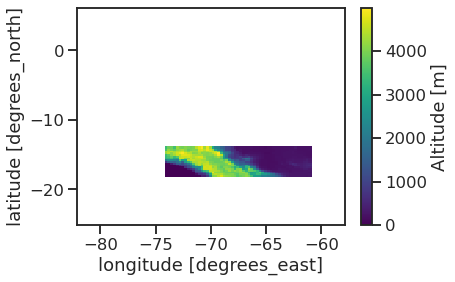

In [249]:
topo_on_era.plot()

In [257]:
isbuffer = altiplano
era_valley = era['v'].mean(['latitude', 'longitude']) #salem.roi(shape=sdf)  #'v'
ets = season_mean(era_valley)

In [258]:
era2 = readERA('u200')
era2 = era2.sel(longitude=slice(isbuffer[0], isbuffer[1]), latitude=slice(isbuffer[2], isbuffer[3]))
era2_valley = era2['u'].mean(['latitude', 'longitude']) #salem.roi(shape=sdf) ['u']
ets200 = season_mean(era2_valley)

In [259]:
era2 = readERA_coarse('u200')
isatlantic= [-50,-25,0,10]
era2 = era2.sel(longitude=slice(isatlantic[0], isatlantic[1]), latitude=slice(isatlantic[2], isatlantic[3]))
era2_valley = era2.mean(['latitude', 'longitude']) #salem.roi(shape=sdf) ['u']
ets200_atlantic = season_mean(era2_valley)

In [260]:
era2 = readERA_coarse('u850')
isatlantic= [-50,-25,0,10]
era2 = era2.sel(longitude=slice(isatlantic[0], isatlantic[1]), latitude=slice(isatlantic[2], isatlantic[3]))
era2_valley = era2.mean(['latitude', 'longitude']) #salem.roi(shape=sdf) ['u']
ets850_atlantic = season_mean(era2_valley)

In [261]:
ets200_atlantic

<xarray.DataArray (time: 43)>
array([ 8.9362289 ,  8.22525725, 11.22356436,  6.9529354 , 18.42593463,
        7.43358314,  7.78330778,  9.37059255, 16.44679633, 10.05854518,
        7.73848012, 13.62676627, 10.72022744, 14.80587096, 13.42993623,
        8.33982185, 10.34544849,  5.89604602,  9.6517748 , 17.37084759,
        5.22272414,  1.98914053, 11.21036306, 11.60158591, 12.00001614,
        4.95769704,  7.41168873,  7.89131062,  8.80123111,  6.84223729,
        5.9758012 , 14.16675067,  3.10624359,  9.18805887, 10.69498336,
       13.32803128, 14.88955529, 16.47167765,  6.37122416,  9.49473047,
       14.5948437 , 11.25077711, 11.54668522])
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1980-01-01 ... 2021-01-01
    expver   int32 1
    level    int32 200

In [262]:
isbuffer = tbox
era2 = readERA_coarse('t850')
era2 = era2.sel(longitude=slice(isbuffer[0], isbuffer[1]), latitude=slice(isbuffer[2], isbuffer[3]))
era2_valley = era2.mean(['latitude', 'longitude']) #salem.roi(shape=sdf) ['u']
ett850 = season_mean(era2_valley)

In [263]:
isbuffer = isjet
era2 = readERA_coarse('q850')
era2 = era2.sel(longitude=slice(isbuffer[0], isbuffer[1]), latitude=slice(isbuffer[2], isbuffer[3]))
era2_valley = era2.mean(['latitude', 'longitude']) #salem.roi(shape=sdf) ['u']
etq850 = season_mean(era2_valley)

In [264]:
posgrid = np.intersect1d(ets.time, gts.time)

gsat = gts.sel(time=posgrid)
ets = ets.sel(time=posgrid)


posgrid = np.intersect1d(ets.time, cts.time)
cts = cts.sel(time=posgrid)
ets200 = ets200.sel(time=posgrid)

AttributeError: 'Series' object has no attribute 'time'

In [265]:
ett850 = ett850.sel(time=posgrid)
etq850 = etq850.sel(time=posgrid)

In [266]:
ets200_atlantic =  ets200_atlantic.sel(time=posgrid)
ets850_atlantic =  ets850_atlantic.sel(time=posgrid)

In [267]:
etq850 = etq850.to_pandas()
ett850 = ett850.to_pandas()
ets200 = ets200.to_pandas()
ets = ets.to_pandas()
gts = gts.to_pandas()
cts = cts.to_pandas()
#nts = nts.to_pandas()

AttributeError: 'Series' object has no attribute 'to_pandas'

In [268]:
ets200_atlantic = ets200_atlantic.to_pandas()
ets850_atlantic = ets850_atlantic.to_pandas()

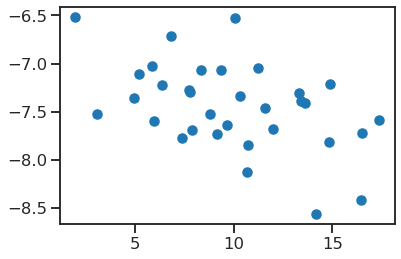

In [221]:
plt.scatter(ets200_atlantic,ets850_atlantic)

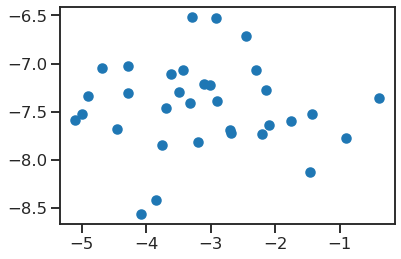

In [222]:
plt.scatter(ets,ets850_atlantic)

In [223]:
nts = nts.to_pandas()

NameError: name 'nts' is not defined

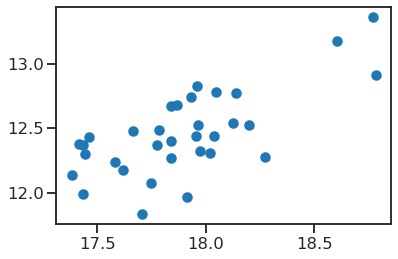

In [224]:
plt.scatter(ett850-273.15, etq850*1000)

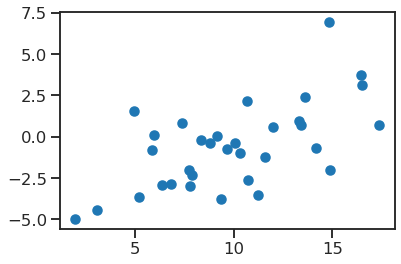

In [225]:
plt.scatter(ets200_atlantic, ets200)

In [226]:
plt.scatter(nts.loc[nts.index.year<=2017], ets200.loc[(ets200.index.year>=2000)])

NameError: name 'nts' is not defined

In [227]:
nts.loc[nts.index.year<=2017]

NameError: name 'nts' is not defined

In [228]:
enso = '/home/ck/DIR/mymachine/ENSO/ONI.csv'#'/home/ck/DIR/mymachine/ENSO/meiv2.data'
nao =  '/home/ck/DIR/mymachine/ENSO/NAO.csv'

In [229]:
ysst_start = 1980#ets.index[0].year
ysst_end = 2019 #ets.index[-1].year

In [230]:
ens = pd.read_csv(enso, sep=',', engine='python', names=np.arange(0, 13),index_col=0)
naos = pd.read_csv(nao, sep='  ', engine='python', names=np.arange(0, 13),index_col=0)
ensmonth = ens[1:3]
naomonth = naos[1:3]
eens = ensmonth.loc[ysst_start:ysst_end]
nnao = naomonth.loc[ysst_start:ysst_end]

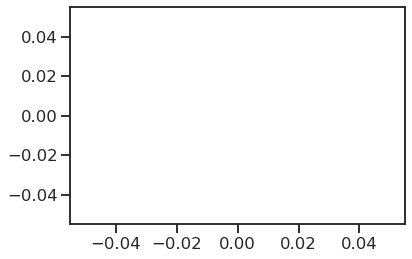

In [231]:
plt.plot(eens)
plt.plot(nnao)

In [232]:
yens = ens.mean(axis = 1, skipna = True)[0:-1]
ynao =  naos.mean(axis = 1, skipna = True)[0:-1]

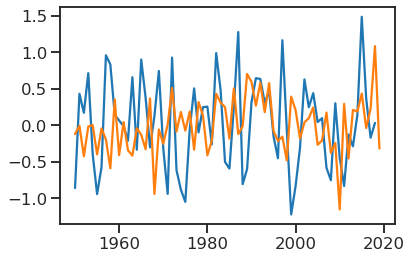

In [233]:
plt.plot(yens[0:-1])
plt.plot(ynao[0:-1])

In [234]:
yy1 = 2000
yy2 = 2017

In [235]:
stats.pearsonr(nts[(nts.index.year>=yy1)&(nts.index.year<=yy2)], gts[(gts.index.year>=yy1)&(gts.index.year<=yy2)])

NameError: name 'nts' is not defined

In [236]:
stats.pearsonr(nts[(nts.index.year>=yy1)&(nts.index.year<=yy2)], cts[(cts.index.year>=yy1)&(cts.index.year<=yy2)])

NameError: name 'nts' is not defined

In [237]:
stats.pearsonr(gts[(gts.index.year>=yy1)&(gts.index.year<=yy2)], ensmonth.loc[yy1:yy2])

ValueError: x and y must have the same length.

In [238]:
stats.pearsonr(ets200_atlantic[(ets200_atlantic.index.year>=yy1)&(ets200_atlantic.index.year<=yy2)], ensmonth.loc[yy1:yy2])

ValueError: x and y must have the same length.

In [180]:
stats.pearsonr(ets200[(ets200.index.year>=yy1)&(ets200.index.year<=yy2)],ets200_atlantic[(ets200_atlantic.index.year>=yy1)&(ets200_atlantic.index.year<=yy2)])

(0.6585601122783556, 0.002960289189813436)

In [181]:
ccbar = []
for enb in eens.values:
    if enb < -0.5:
        ccbar.append('lightblue')
    elif enb > 0.5:
        ccbar. append('red')
    else:
        ccbar.append('k')

In [182]:
ets.index

DatetimeIndex(['1985-01-01', '1986-01-01', '1987-01-01', '1988-01-01',
               '1989-01-01', '1990-01-01', '1991-01-01', '1992-01-01',
               '1993-01-01', '1994-01-01', '1995-01-01', '1996-01-01',
               '1997-01-01', '1998-01-01', '1999-01-01', '2000-01-01',
               '2001-01-01', '2002-01-01', '2003-01-01', '2004-01-01',
               '2005-01-01', '2006-01-01', '2007-01-01', '2008-01-01',
               '2009-01-01', '2010-01-01', '2011-01-01', '2012-01-01',
               '2013-01-01', '2014-01-01', '2015-01-01', '2016-01-01',
               '2017-01-01'],
              dtype='datetime64[ns]', name='time', freq=None)

In [184]:
stats.linregress(np.arange(len(ets200_atlantic)), ets200_atlantic)

LinregressResult(slope=-0.027758255386973026, intercept=10.374580033031956, rvalue=-0.0686067327596463, pvalue=0.7044155384129915, stderr=0.07249700792377682)

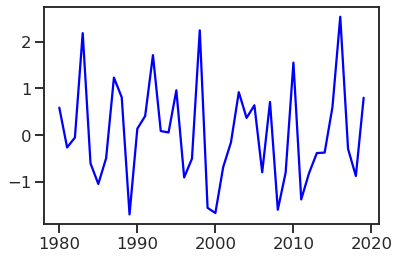

In [185]:
plt.plot(eens.index, eens, color='blue')

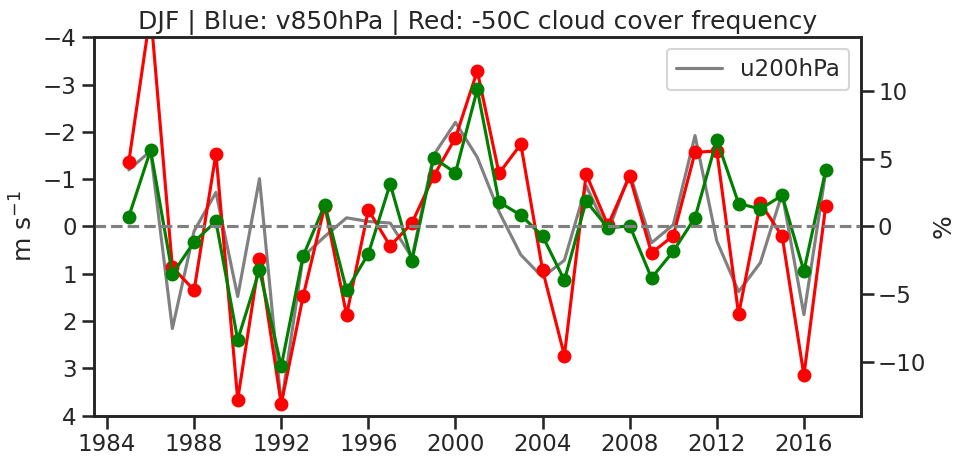

In [240]:
f=plt.figure(figsize=(10,5), dpi=100)
ax = f.add_subplot(111)
#ax.plot((ett850-np.mean(ett850))*3, marker='o', label='v850hPa')

ax.plot((ets200-np.mean(ets200))/2, label='u200hPa', color='grey')
#ax.plot(ets.index, eens, color='k')
#ax.scatter(ets.index, eens, marker='x', color=ccbar)
plt.legend()
ax1 = ax.twinx()
ax1.plot((gts-np.mean(gts)), color='r', marker='o', label='-50C cloud cover frequency')
#ax1.plot((nts-np.mean(nts))*500, marker='o', label='v850hPa', color='blue')
ax1.plot((cts-np.mean(cts))/5, marker='o', label='v850hPa', color='green')
#print(ets.index[10:-5],stats.linregress(ets.values[10:-5], gts.values[10:-5]))
plt.title('DJF | Blue: v850hPa | Red: -50C cloud cover frequency')
ax1.set_ylabel('%')
ax.set_ylabel('m s$^{-1}$')
ax1.set_ylabel('%')
ax.set_ylabel('m s$^{-1}$')
ax.set_ylim(-4,4)
ax.set_ylim(ax.get_ylim()[::-1])
ax1.set_ylim(-14,14)
plt.axhline(0, linestyle='dashed', color='grey')
plt.tight_layout()
#f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/correlations/interannual_timeseries_corr_GRIDSATvsv850WAmazon_Altiplano.jpg')

DatetimeIndex(['1995-01-01', '1996-01-01', '1997-01-01', '1998-01-01',
               '1999-01-01', '2000-01-01', '2001-01-01', '2002-01-01',
               '2003-01-01', '2004-01-01', '2005-01-01', '2006-01-01',
               '2007-01-01', '2008-01-01', '2009-01-01', '2010-01-01',
               '2011-01-01', '2012-01-01'],
              dtype='datetime64[ns]', name='time', freq=None) LinregressResult(slope=-0.9481517585400508, intercept=35.154019305430644, rvalue=-0.27669479654162255, pvalue=0.26634563591330124, stderr=0.8232300415412669)


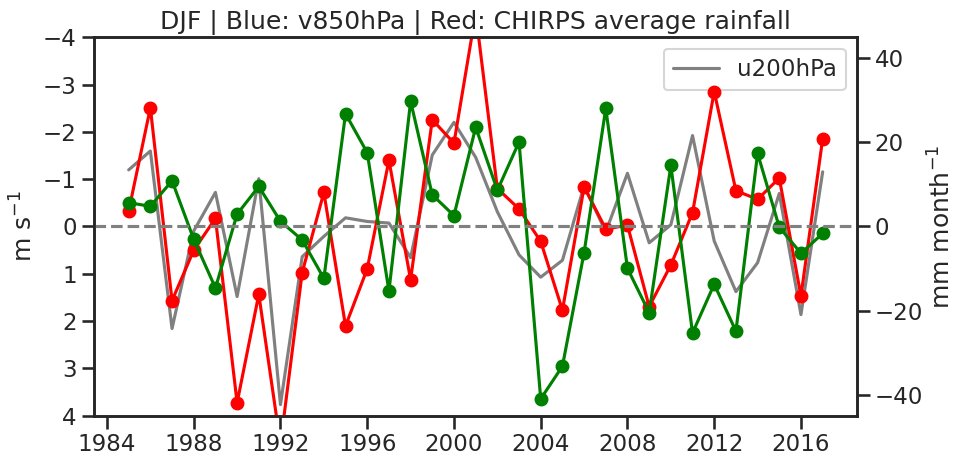

In [244]:
f=plt.figure(figsize=(10,5), dpi=100)
ax = f.add_subplot(111)
#ax.plot((ets-np.mean(ets)), marker='o', label='v850hPa')

ax.plot((ets200-np.mean(ets200))/2, label='u200hPa', color='grey')
plt.legend()
#ax.plot((ets-np.mean(ets)).rolling(center=True,window=10).mean()*-1, color='purple')
ax1 = ax.twinx()
ax1.plot((cts-np.mean(cts)), color='r', marker='o', label='CHIRPS average rainfall')
ax1.plot((ets-np.mean(ets))*-15, marker='o', label='v850hPa', color='green')
print(ets.index[10:-5],stats.linregress(ets.values[10:-5], gts.values[10:-5]))
plt.title('DJF | Blue: v850hPa | Red: CHIRPS average rainfall')

plt.axhline(0, linestyle='dashed', color='grey')
ax.set_ylim(-4,4)
ax.set_ylim(ax.get_ylim()[::-1])
ax1.set_ylim(-45,45)

ax1.set_ylabel('mm month$^{-1}$')
ax.set_ylabel('m s$^{-1}$')
plt.tight_layout()
#f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/correlations/interannual_timeseries_corr_CHIRPSv850WAmazon_Altiplano.jpg')

In [85]:
stats.pearsonr(nts[(nts.index.year>=yy1)&(nts.index.year<=yy2)], cts[(cts.index.year>=yy1)&(cts.index.year<=yy2)])

NameError: name 'nts' is not defined

In [86]:
stats.pearsonr(nts[(nts.index.year>=yy1)&(nts.index.year<=yy2)], gts[(gts.index.year>=yy1)&(gts.index.year<=yy2)])

NameError: name 'nts' is not defined

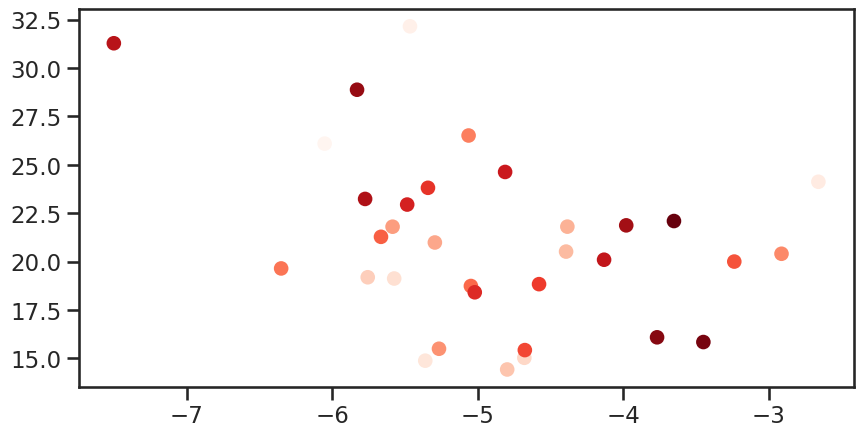

In [87]:
f=plt.figure(figsize=(10,5), dpi=100)
ax = f.add_subplot(111)
plt.scatter(ets,gts, c=ets.index, cmap='Reds')

### Trend analysis 

In [88]:
# the trend are computed on time series at least 20yrs long
start_years = ets.index[:-5]
start_years_p = start_years.year
end_years = ets.index[5:]
end_years_p = end_years.year
ny = len(start_years)
extent = (start_years_p[0], start_years_p[-1], end_years_p[0], end_years_p[-1])  # needed for the plot later

In [89]:
extent

(1985, 2012, 1990, 2017)

In [90]:
# fill the triangle
trend = np.zeros((ny, ny)) *np.nan
sig = np.ones((ny, ny)) 
for i, start_year in enumerate(start_years):
    for j, end_year in enumerate(end_years):
        data1 = ets.loc[start_year:end_year]
        data2 = ets200.loc[start_year:end_year]
        if len(data1) < 5:
            continue
        slope, intercept, r, p_val, stderr = stats.linregress(data1.values, data2.values)
        trend[j, i] = r   # for decadal trends
        sig[j, i] = p_val

In [91]:
trend = np.array(trend)
sig = np.array(sig)

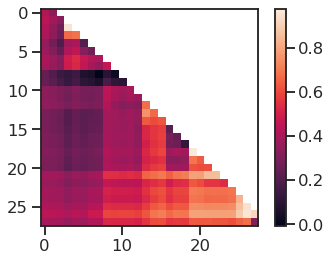

In [92]:
plt.imshow(trend)
plt.colorbar()

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: No contour levels were found within the data range.
  


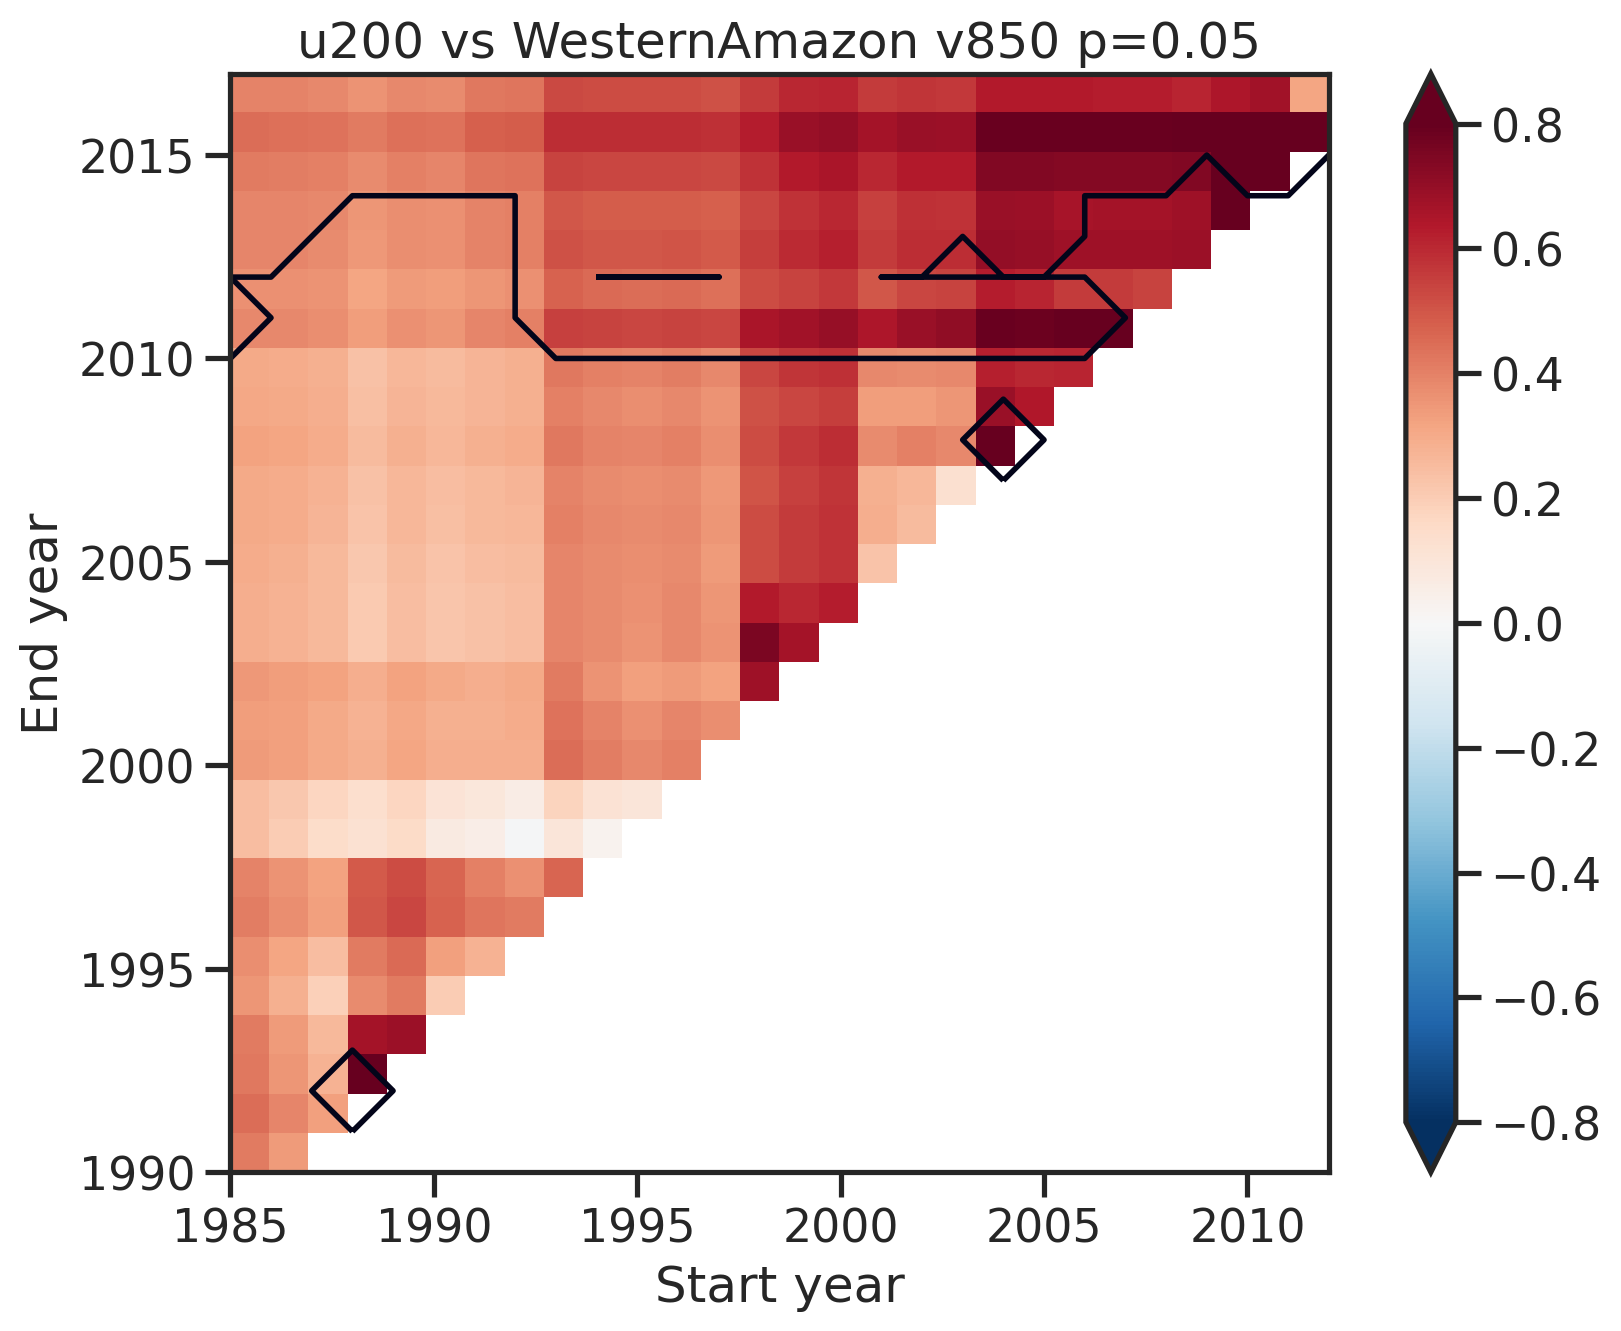

In [93]:
# plot
f= plt.figure(figsize=(9, 7),dpi=200)
ax = f.add_subplot(111)
im = plt.imshow(trend, cmap=cmap, vmin=-0.8, vmax=0.8, extent=extent, interpolation='none', origin='lower')  #, 
#im = plt.contourf(start_years, end_years, trend, linewidths=1, levels=np.arange(-0.8,0.81,0.1), cmap='RdBu_r')
plt.contour(start_years_p, end_years_p, sig < 0.05, linewidths=2, levels=[-1,0,1])
plt.colorbar(im, extend='both');
# ax.set_xtick_labels(start_years_p)
# ax.set_ytick_labels(end_years_p)
plt.title('u200 vs WesternAmazon v850 p=0.05');
plt.xlabel('Start year');
plt.ylabel('End year');
plt.tight_layout()

#f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/correlations/triangle_DJF_u200vsv850WesternAmazon_Altiplano.jpg')

In [94]:
# fill the triangle
trend = np.zeros((ny, ny)) * np.NaN
sig = np.ones((ny, ny)) 
for i, start_year in enumerate(start_years):
    for j, end_year in enumerate(end_years):
        data1 = ets.loc[start_year:end_year]
        data2 = gts.loc[start_year:end_year]
        if len(data1) < 5:
            continue
        slope, intercept, r, p_val, stderr = stats.linregress(data1.values, data2.values)
        trend[j, i] = r   # for decadal trends
        sig[j, i] = p_val

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: No contour levels were found within the data range.
  """


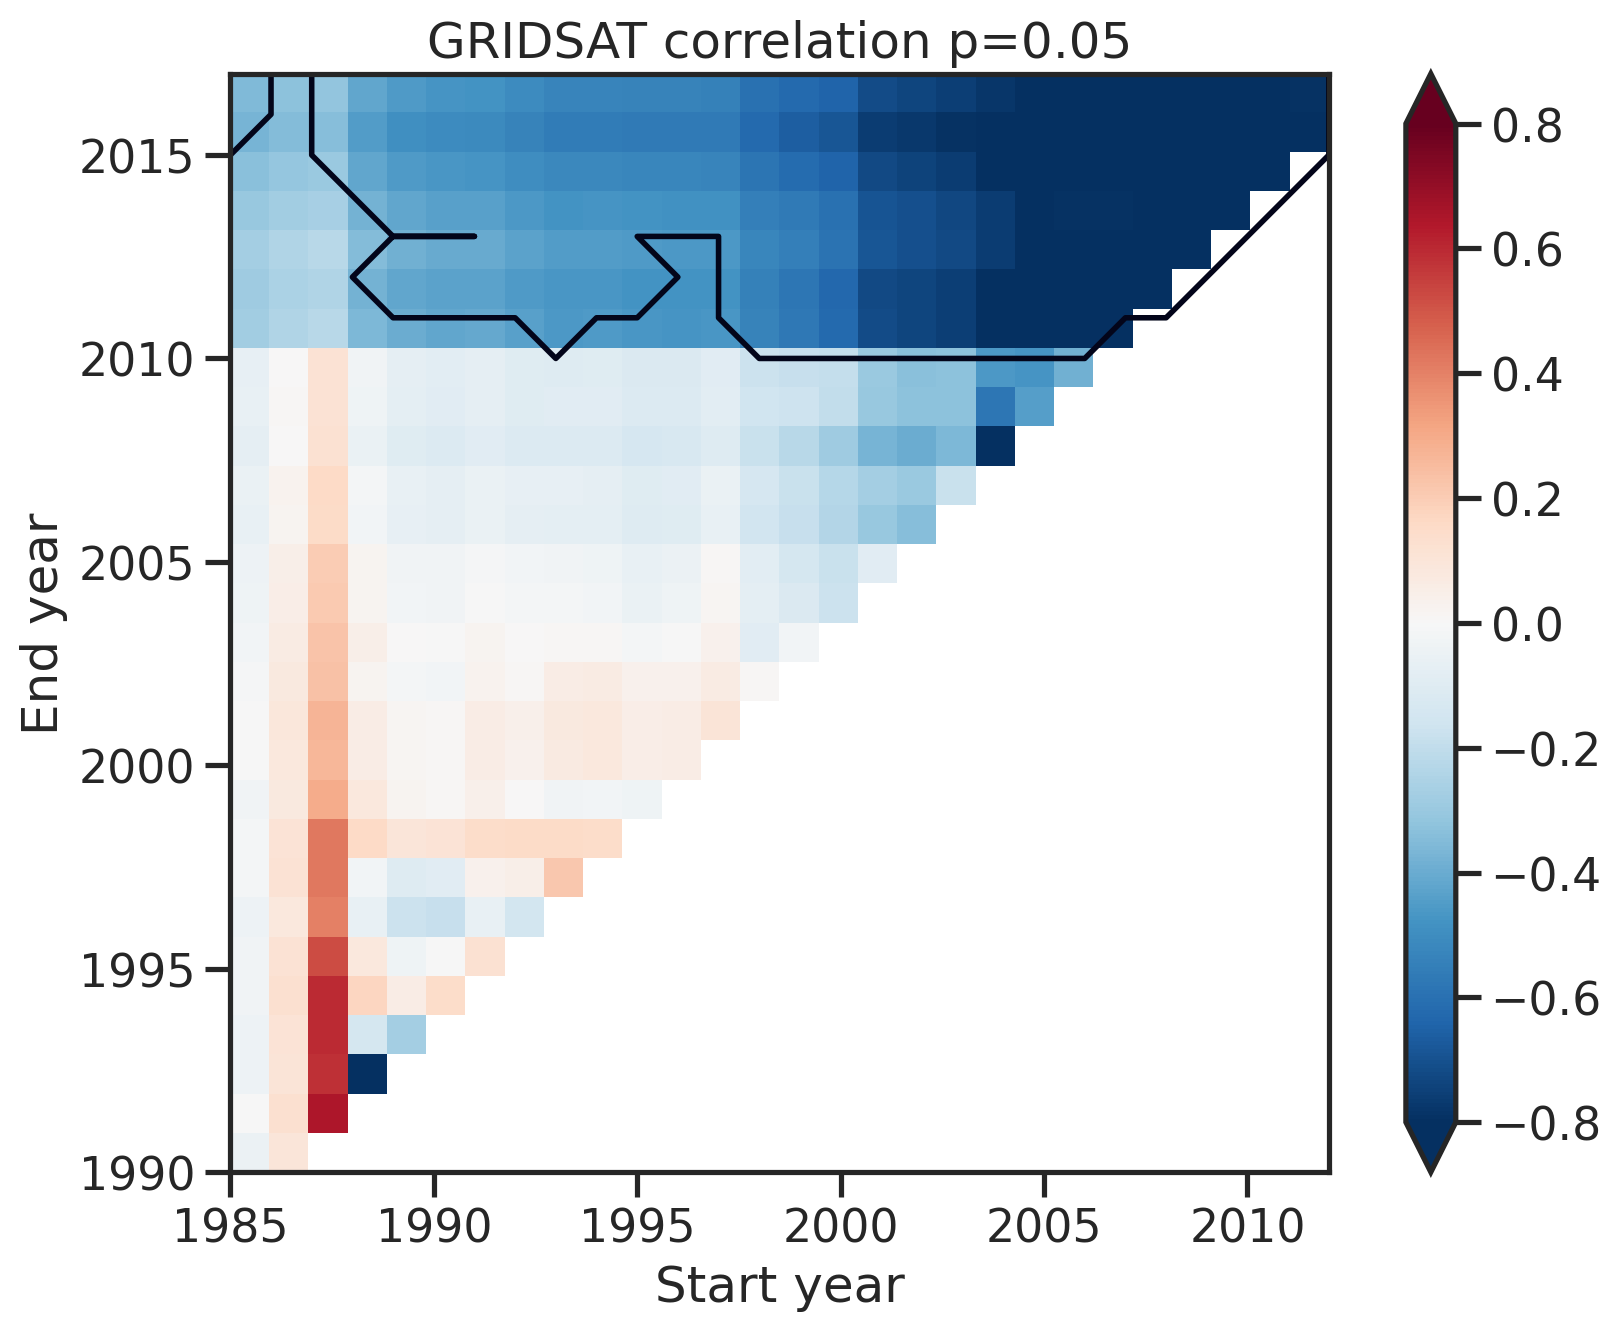

In [95]:
f= plt.figure(figsize=(9, 7), dpi=200)
ax = f.add_subplot(111)
im = plt.imshow(trend, cmap=cmap, vmin=-0.8, vmax=0.8, extent=extent, interpolation='none', origin='lower')  #, 
#im = plt.contourf(start_years, end_years, trend, linewidths=1, levels=np.arange(-0.8,0.81,0.1), cmap='RdBu_r')
plt.contour(start_years_p, end_years_p, sig < 0.05, linewidths=2, levels=[-1,0,1])
plt.colorbar(im, extend='both');
plt.title('GRIDSAT correlation p=0.05');
plt.xlabel('Start year');
plt.ylabel('End year');
plt.tight_layout()
#plt.savefig('triangle_giss.png', dpi=150)
#f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/correlations/triangle_DJF_GRIDSATvsv850WesternAmazon_Altiplano.jpg')

In [96]:
# fill the triangle
trend = np.zeros((ny, ny)) * np.NaN
sig = np.ones((ny, ny)) 
for i, start_year in enumerate(start_years):
    for j, end_year in enumerate(end_years):
        #ipdb.set_trace()
        data1 = yens.loc[start_year.year:end_year.year]
        data2 = ynao.loc[start_year.year:end_year.year]
        if len(data1) < 5:
            continue
        slope, intercept, r, p_val, stderr = stats.linregress(data1.values, data2.values)
        trend[j, i] = r   # for decadal trends
        sig[j, i] = p_val

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: No contour levels were found within the data range.
  """


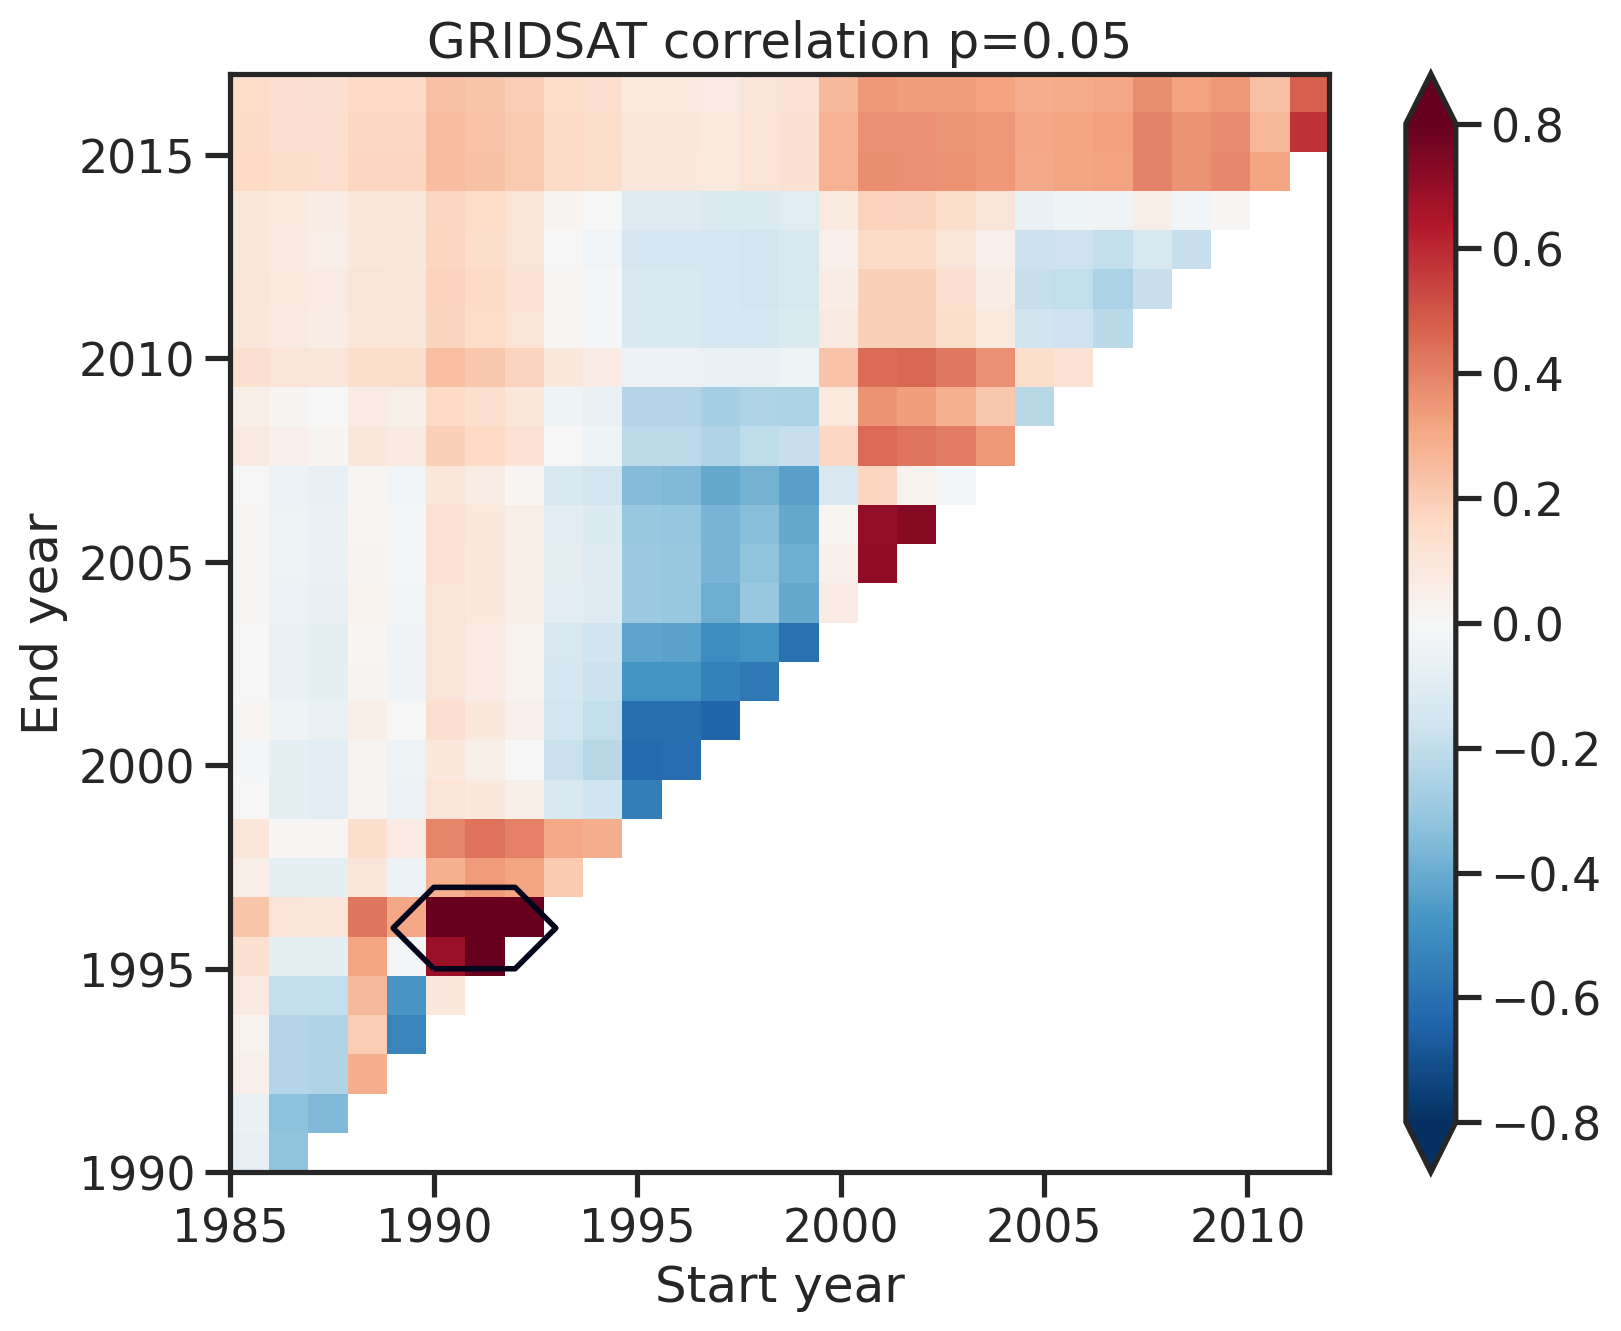

In [97]:
f= plt.figure(figsize=(9, 7), dpi=200)
ax = f.add_subplot(111)
im = plt.imshow(trend, cmap=cmap, vmin=-0.8, vmax=0.8, extent=extent, interpolation='none', origin='lower')  #, 
#im = plt.contourf(start_years, end_years, trend, linewidths=1, levels=np.arange(-0.8,0.81,0.1), cmap='RdBu_r')
plt.contour(start_years_p, end_years_p, sig < 0.05, linewidths=2, levels=[-1,0,1])
plt.colorbar(im, extend='both');
plt.title('GRIDSAT correlation p=0.05');
plt.xlabel('Start year');
plt.ylabel('End year');
plt.tight_layout()
#plt.savefig('triangle_giss.png', dpi=150)
#f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/correlations/triangle_DJF_GRIDSATvsv850WesternAmazon_Altiplano.jpg')

In [98]:
def monthly(m, d1,d2):

    dg = d1.sel(time=(d1['time.month']==m)).groupby('time.year').mean('time')
    de = d2.sel(time=(d2['time.month']==m)).groupby('time.year').mean('time')
                 
    posgrid = np.intersect1d(dg.year.values, de.year.values)

    de = de.sel(year=posgrid)
    dg = dg.sel(year=posgrid)
                 
    dg = dg.to_pandas()
    de = de.to_pandas()
                 
    # fill the triangle
    trend = np.zeros((ny, ny)) * np.NaN
    sig = np.ones((ny, ny)) 
    for i, start_year in enumerate(start_years_p):
        for j, end_year in enumerate(end_years_p):
            data1 = dg.loc[start_year:end_year]
            data2 = de.loc[start_year:end_year]
            if len(data1) < 5:
                continue
            slope, intercept, r, p_val, stderr = stats.linregress(data1.values, data2.values)
            trend[j, i] = r   # for decadal trends
            sig[j, i] = p_val
    
    return trend, sig

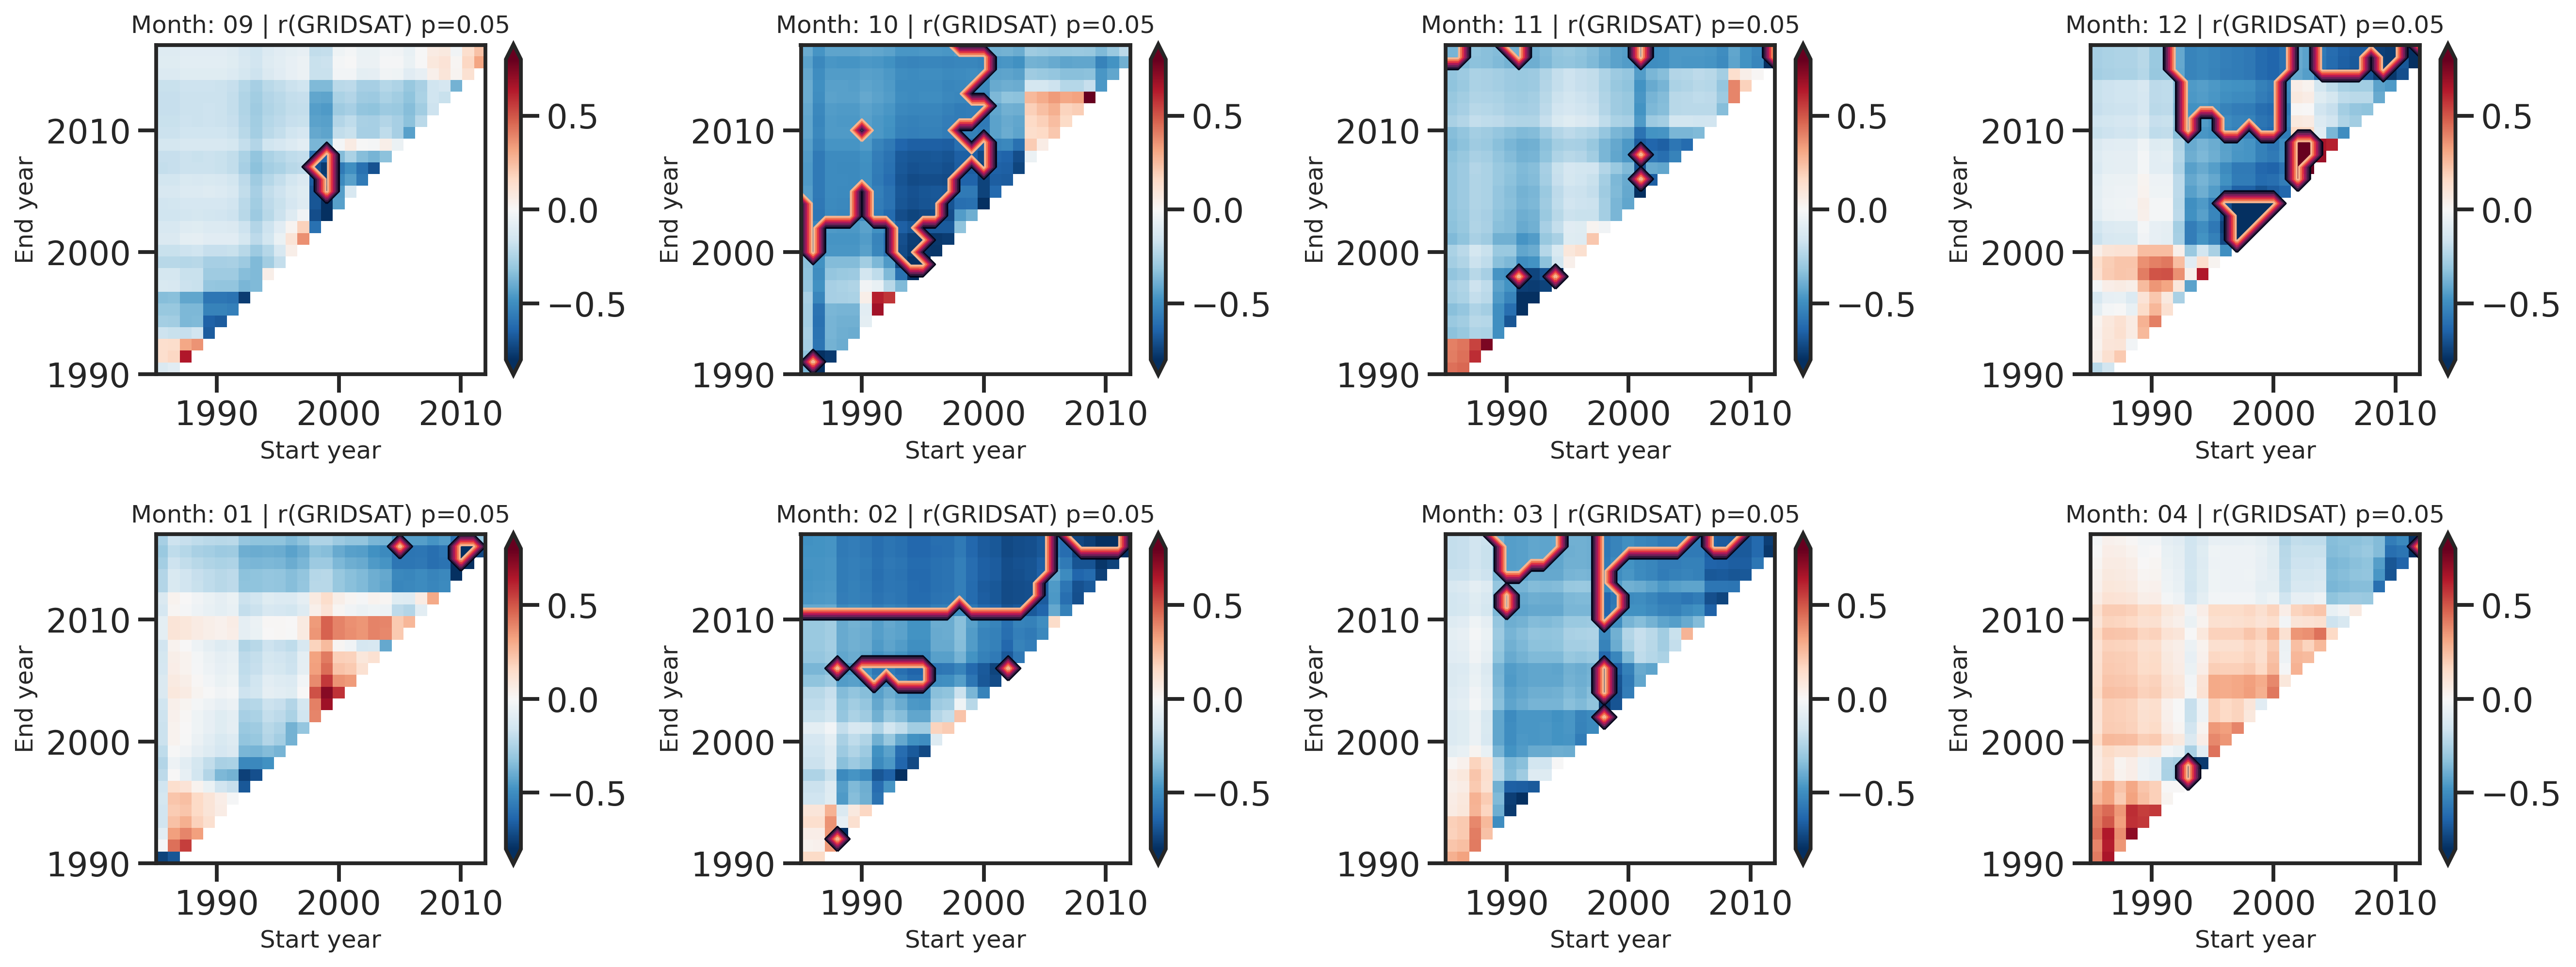

In [99]:
f = plt.figure(figsize=(18,7), dpi=300)
months = [9,10,11,12,1,2,3,4]

for ids, m in enumerate(months): 
    
    trend, sig = monthly(m, era_valley,da3)
    

    ax = f.add_subplot(2,4,ids+1)
        
    im = plt.imshow(trend, extent=extent, interpolation='none', origin='lower', cmap=cmap, vmin=-0.8, vmax=0.8)
    plt.contour(start_years_p, end_years_p, sig < 0.05, linewidths=1)
    plt.colorbar(im, extend='both');
    plt.title('Month: '+str(m).zfill(2)+' | r(GRIDSAT) p=0.05', fontsize=12);
    plt.xlabel('Start year', fontsize=12);
    plt.ylabel('End year', fontsize=12);

plt.tight_layout() 
#f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/correlations/triangle_monthly_GRIDSATvsU200_Altiplano.jpg')

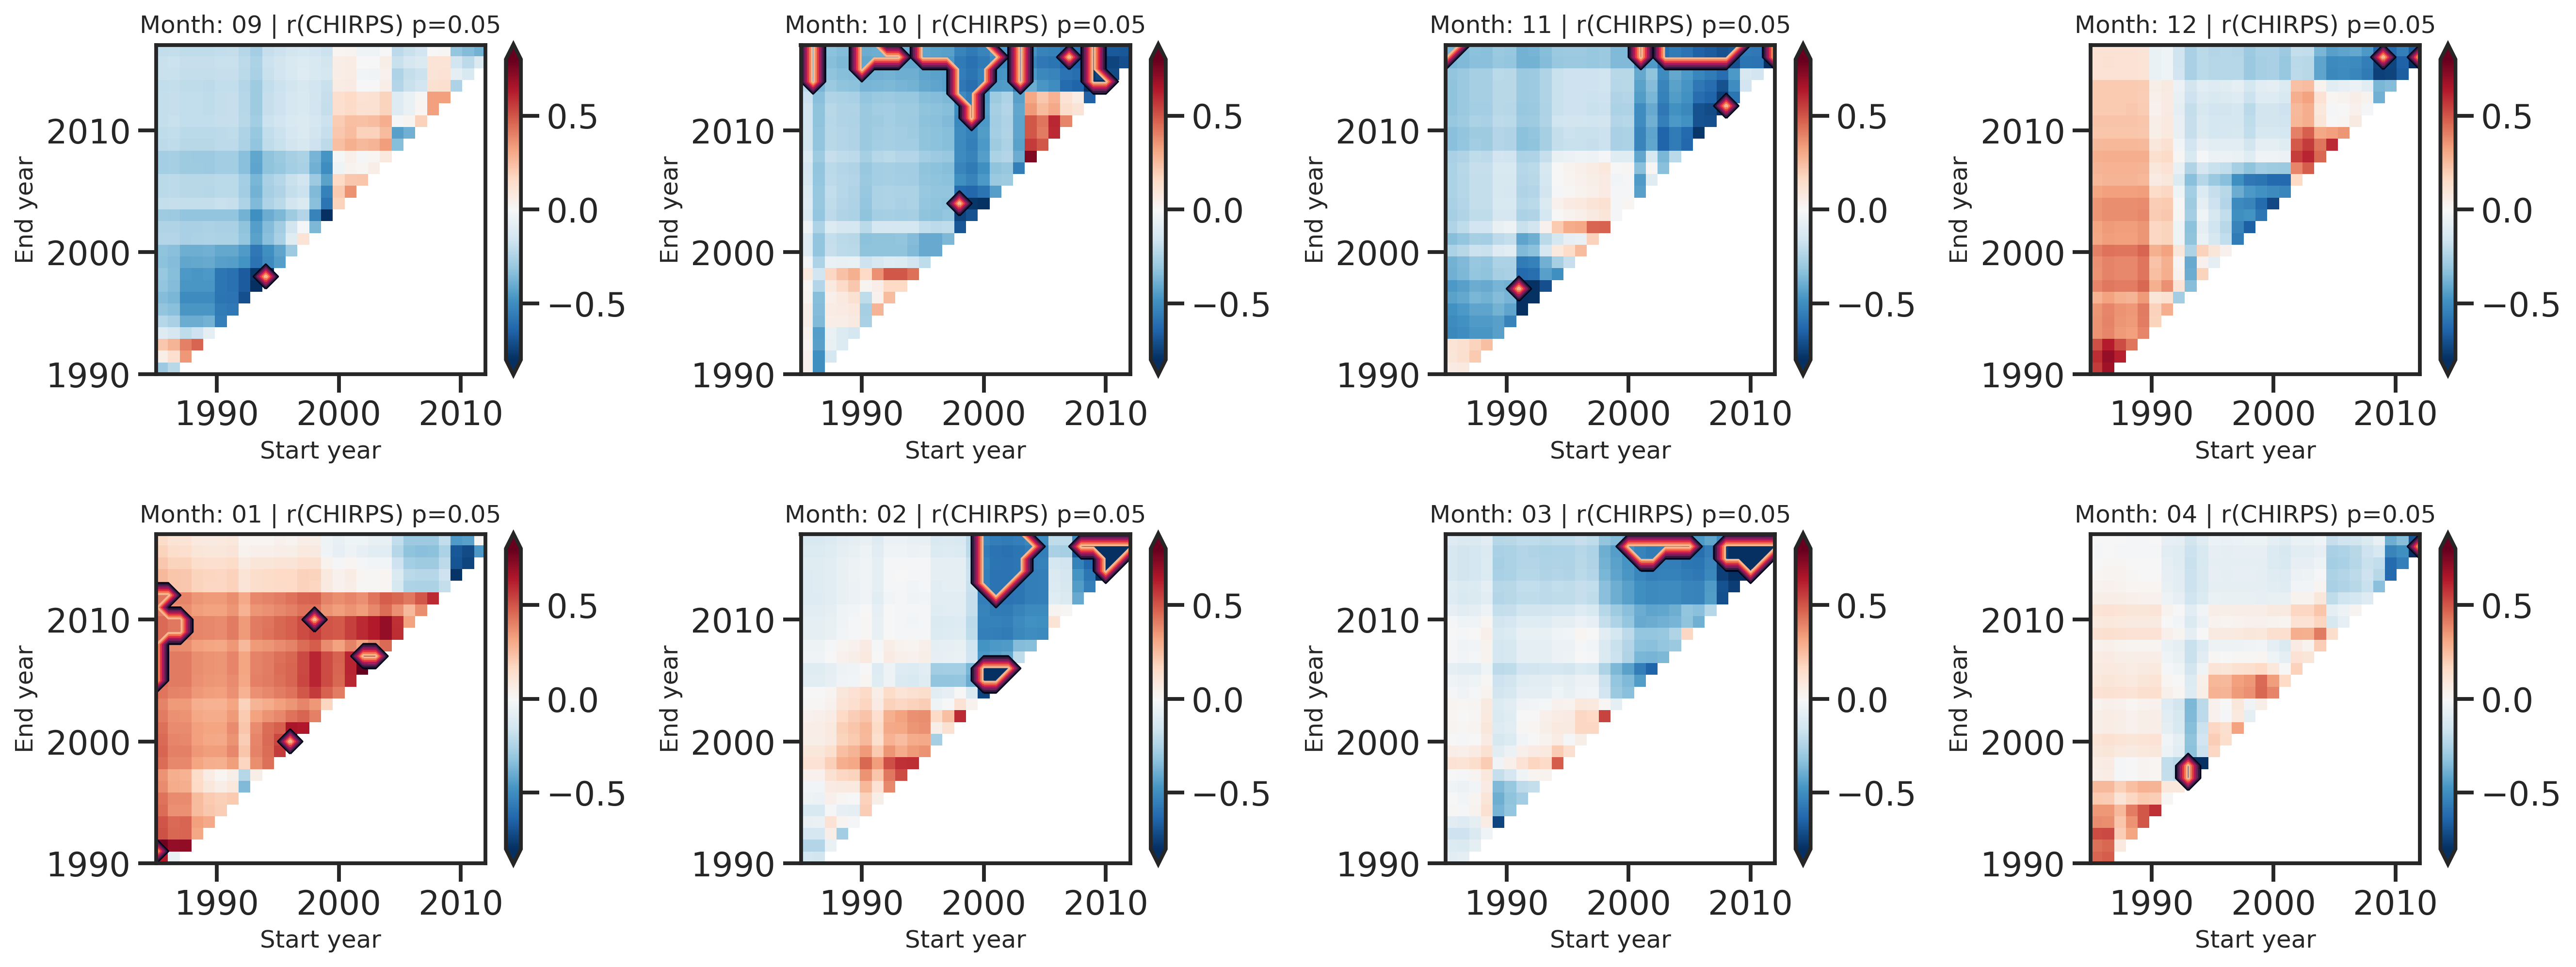

In [100]:
f = plt.figure(figsize=(18,7), dpi=300)
months = [9,10,11,12,1,2,3,4]

for ids, m in enumerate(months): 
    
    trend, sig = monthly(m, era_valley,ca)
    

    ax = f.add_subplot(2,4,ids+1)
        
    im = plt.imshow(trend, extent=extent, interpolation='none', origin='lower', cmap=cmap, vmin=-0.8, vmax=0.8)
    plt.contour(start_years_p, end_years_p, sig < 0.05, linewidths=1)
    plt.colorbar(im, extend='both');
    plt.title('Month: '+str(m).zfill(2)+' | r(CHIRPS) p=0.05', fontsize=12);
    plt.xlabel('Start year', fontsize=12);
    plt.ylabel('End year', fontsize=12);
plt.tight_layout() 
#f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/correlations/triangle_monthly_CHIRPSvsU200_Altiplano.jpg')

In [101]:
sst = xr.open_mfdataset('/media/ck/Elements/global/ERA5/monthly/uv/ERA5_monthly_0.7deg_*.nc')

In [102]:
sst_full = uda.flip_lat(sst)

In [103]:
ysst_start = ets.index[0].year
ysst_end = ets.index[-1].year

In [104]:
sst = sst_full['u'].isel(time=(sst_full['time.year']>=ysst_start)&(sst_full['time.year']<=ysst_end)).sel(latitude=slice(-50,50))

In [105]:
sst

<xarray.DataArray 'u' (time: 396, level: 3, latitude: 143, longitude: 515)>
dask.array<getitem, shape=(396, 3, 143, 515), dtype=float32, chunksize=(12, 3, 143, 515), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 0.0 0.7 1.4 2.1 ... 357.7 358.4 359.1 359.8
  * latitude   (latitude) float32 -49.7 -49.0 -48.3 -47.6 ... 48.3 49.0 49.7
  * level      (level) int32 200 500 850
  * time       (time) datetime64[ns] 1985-01-01 1985-02-01 ... 2017-12-01
Attributes:
    units:          m s**-1
    long_name:      U component of wind
    standard_name:  eastward_wind

In [106]:
# Wrap it into a simple function
def season_mean_sst(ds, calendar='standard'):
    # Make a DataArray of season/year groups
#     year_season = xr.DataArray(ds.time.to_index().to_period(freq='Q-NOV').to_timestamp(how='E'),
#                                coords=[ds.time], name='year_season')

    month_length = xr.DataArray(get_dpm(ds.time.to_index(), calendar='standard'),coords=[ds.time],name='month_length')
    result = ((ds * month_length).resample(time='QS-JAN').sum('time') /  month_length.where(ds.notnull()).resample(time='QS-JAN').sum('time'))  #QS-DEC

    # Calculate the weighted average
    #ipdb.set_trace()
    return result[result['time.month']==1]

In [107]:
sst_season = season_mean_sst(sst)

In [108]:
sst_season = sst_season.sel(level=850).load()

In [109]:
mask = np.isnan(sst_season.sum('time'))

In [110]:
sst_season.values[np.isnan(sst_season)]=0

In [111]:
sst_season

<xarray.DataArray (time: 33, latitude: 143, longitude: 515)>
array([[[14.50318417, 14.4743519 , 14.46024126, ..., 14.54762711,
         14.53531244, 14.5110979 ],
        [14.62626943, 14.59315466, 14.55092273, ..., 14.64849095,
         14.64778025, 14.63860337],
        [14.64103157, 14.6083115 , 14.55962522, ..., 14.6694298 ,
         14.66510744, 14.64874809],
        ...,
        [ 2.09226952,  2.12335178,  2.1246941 , ...,  2.42535265,
          2.24298403,  2.09592044],
        [ 2.16432126,  2.06704879,  1.96077754, ...,  2.37082454,
          2.23958889,  2.17560925],
        [ 2.00125306,  1.91913645,  1.82541667, ...,  2.08208665,
          2.0648574 ,  2.014199  ]],

       [[13.62064474, 13.56000228, 13.52453058, ..., 13.77526582,
         13.71454758, 13.64006541],
        [14.1754151 , 14.17030258, 14.17590179, ..., 14.22639353,
         14.19395635, 14.18483541],
        [14.53614185, 14.54906431, 14.56340991, ..., 14.50507151,
         14.51670158, 14.53434374],
...
        [ 6.68682722,  6.62971209,  6.5178849 , ...,  6.93032849,
          6.84248967,  6.72425124],
        [ 6.73974901,  6.68812354,  6.45226107, ...,  6.81137493,
          6.91655325,  6.80187775],
        [ 6.6280753 ,  6.56400291,  6.44718006, ...,  6.86497791,
          6.79395011,  6.66425479]],

       [[15.52683262, 15.51930023, 15.52130557, ..., 15.47266031,
         15.50094773, 15.5226785 ],
        [16.32807942, 16.32497212, 16.29809328, ..., 16.26539833,
         16.29937542, 16.32901821],
        [16.85363901, 16.8528255 , 16.84048897, ..., 16.78048142,
         16.82058221, 16.85116445],
        ...,
        [ 4.14661458,  4.26684602,  4.26865273, ...,  4.04620003,
          4.14293033,  4.13057505],
        [ 4.43068318,  4.44612732,  4.3457115 , ...,  4.34983059,
          4.49034691,  4.43971505],
        [ 4.53429616,  4.51597932,  4.46966419, ...,  4.79417638,
          4.70389402,  4.55882573]]])
Coordinates:
  * time       (time) datetime64[ns] 1985-01-01 1986-01-01 ... 2017-01-01
  * longitude  (longitude) float32 0.0 0.7 1.4 2.1 ... 357.7 358.4 359.1 359.8
  * latitude   (latitude) float32 -49.7 -49.0 -48.3 -47.6 ... 48.3 49.0 49.7
    level      int32 850

<AxesSubplot:xlabel='time'>

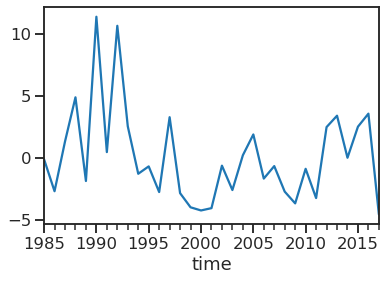

In [112]:
(ets200-ets).plot()

In [113]:
def corr(a, b, bsingle=None, c_box=None):
    ds = xr.Dataset()
    ds['pval'] = a.copy(deep=True).sum('time') * np.nan
    ds['r'] = a.copy(deep=True).sum('time') * np.nan
    ds['slope'] = a.copy(deep=True).sum('time') * np.nan

    corr_box = c_box

    if bsingle:
        bb = b
    else:
        bb = b.sel(latitude=slice(corr_box[2], corr_box[3]), longitude=slice(corr_box[0], corr_box[1])).mean(dim=['latitude', 'longitude'])

    for lat in a.latitude.values:
        for lon in a.longitude.values:
            aa = a.sel(latitude=lat, longitude=lon)
            if bsingle:
                #r, p = stats.pearsonr(aa.values, bb)

                #pf = np.polyfit(aa.values, bb, 1)
                pf, intercept, r, p, std_err = stats.linregress(aa.values, bb)
            else:
                # r, p = stats.pearsonr(aa.values, bb.values)
                # pf = np.polyfit(aa.values, bb.values, 1)
                pf, intercept, r, p, std_err = stats.linregress(aa.values, bb.values)


            slope = pf#[0]

            if (np.nansum(aa.values == 0) >= 10):
                p = np.nan
                r = np.nan

            ds['r'].loc[{'latitude': lat, 'longitude': lon}] = r
            ds['pval'].loc[{'latitude': lat, 'longitude': lon}] = p
            ds['slope'].loc[{'latitude': lat, 'longitude': lon}] = slope
            #ds['intercept'].loc[{'latitude': lat, 'longitude': lon}] = intercept

    return ds

In [114]:
ploops = [(gts,1984, 2000), (gts,2001,2018), (ets,1984,2000), (ets,2001,2019)]
outloops = []

In [115]:
for pl in ploops:
    test = corr(sst_season.isel(time=(sst_season['time.year']>=pl[1]) & (sst_season['time.year']<=pl[2])).load(), pl[0][(pl[0].index.year>=pl[1])&(pl[0].index.year<=pl[2])], bsingle=True)
    print('Did', pl[1])
    outloops.append(test)

Did 1984
Did 2001
Did 1984
Did 2001


/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attrib

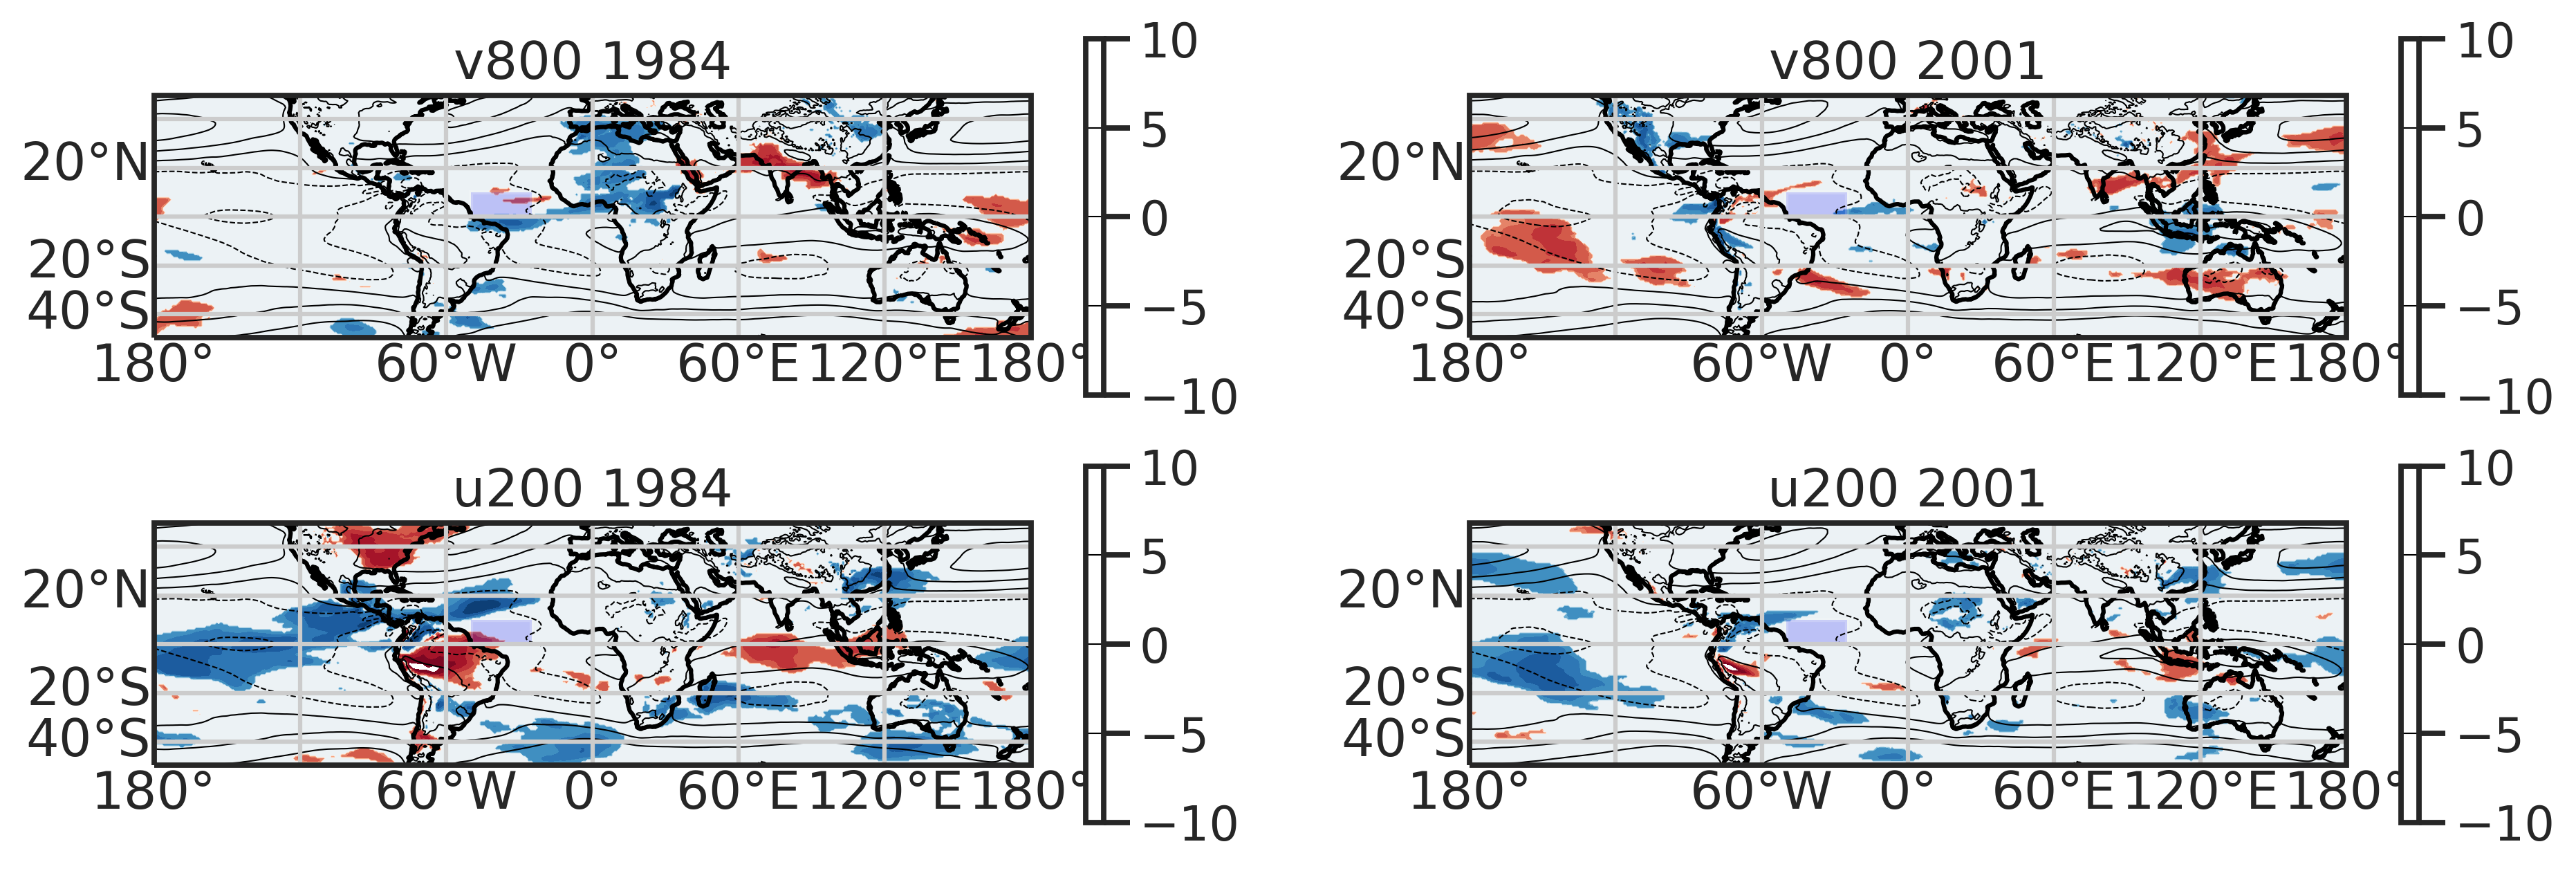

In [81]:
f = plt.figure(figsize=(15,5), dpi=300)
pstr = ['v800', 'v800', 'u200', 'u200']
for ind, dat in enumerate(outloops):
    ax = f.add_subplot(2,2,ind+1, projection=ccrs.PlateCarree())
    ax.coastlines()
    isy = ploops[ind]
        # Gridlines
    xl = ax.gridlines(draw_labels=True);
    xl.xlabels_top = False
    xl.ylabels_right = False
    dats = dat['r'].copy(deep=True)
    dats.values[dat['pval']>0.05] = 0
    tbox = [-50,-25,0,10]
    ax.add_patch(mpatches.Rectangle(xy=[tbox[0], tbox[2]], width=tbox[1]-tbox[0], height=tbox[3]-tbox[2], facecolor='blue', alpha=0.2, transform=ccrs.PlateCarree()))
    
    
    plt.contourf(sst_season.longitude, sst_season.latitude, dats, levels=np.arange(-0.91,0.91,0.1), cmap='RdBu', transform=ccrs.PlateCarree())
    plt.contour(sst_season.longitude, sst_season.latitude, sst_season.isel(time=((sst_season['time.year']>=isy[1]) & (sst_season['time.year']<=isy[2]))).mean('time'), colors='k', linewidths=0.5, transform=ccrs.PlateCarree(), levels=[-10,-5,0,5,10])
    plt.colorbar()
    plt.title(pstr[ind]+' '+str(ploops[ind][1]))
#plt.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/correlations/large_scale/corr_u850_convectionTop_u200Bottom')

/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attrib

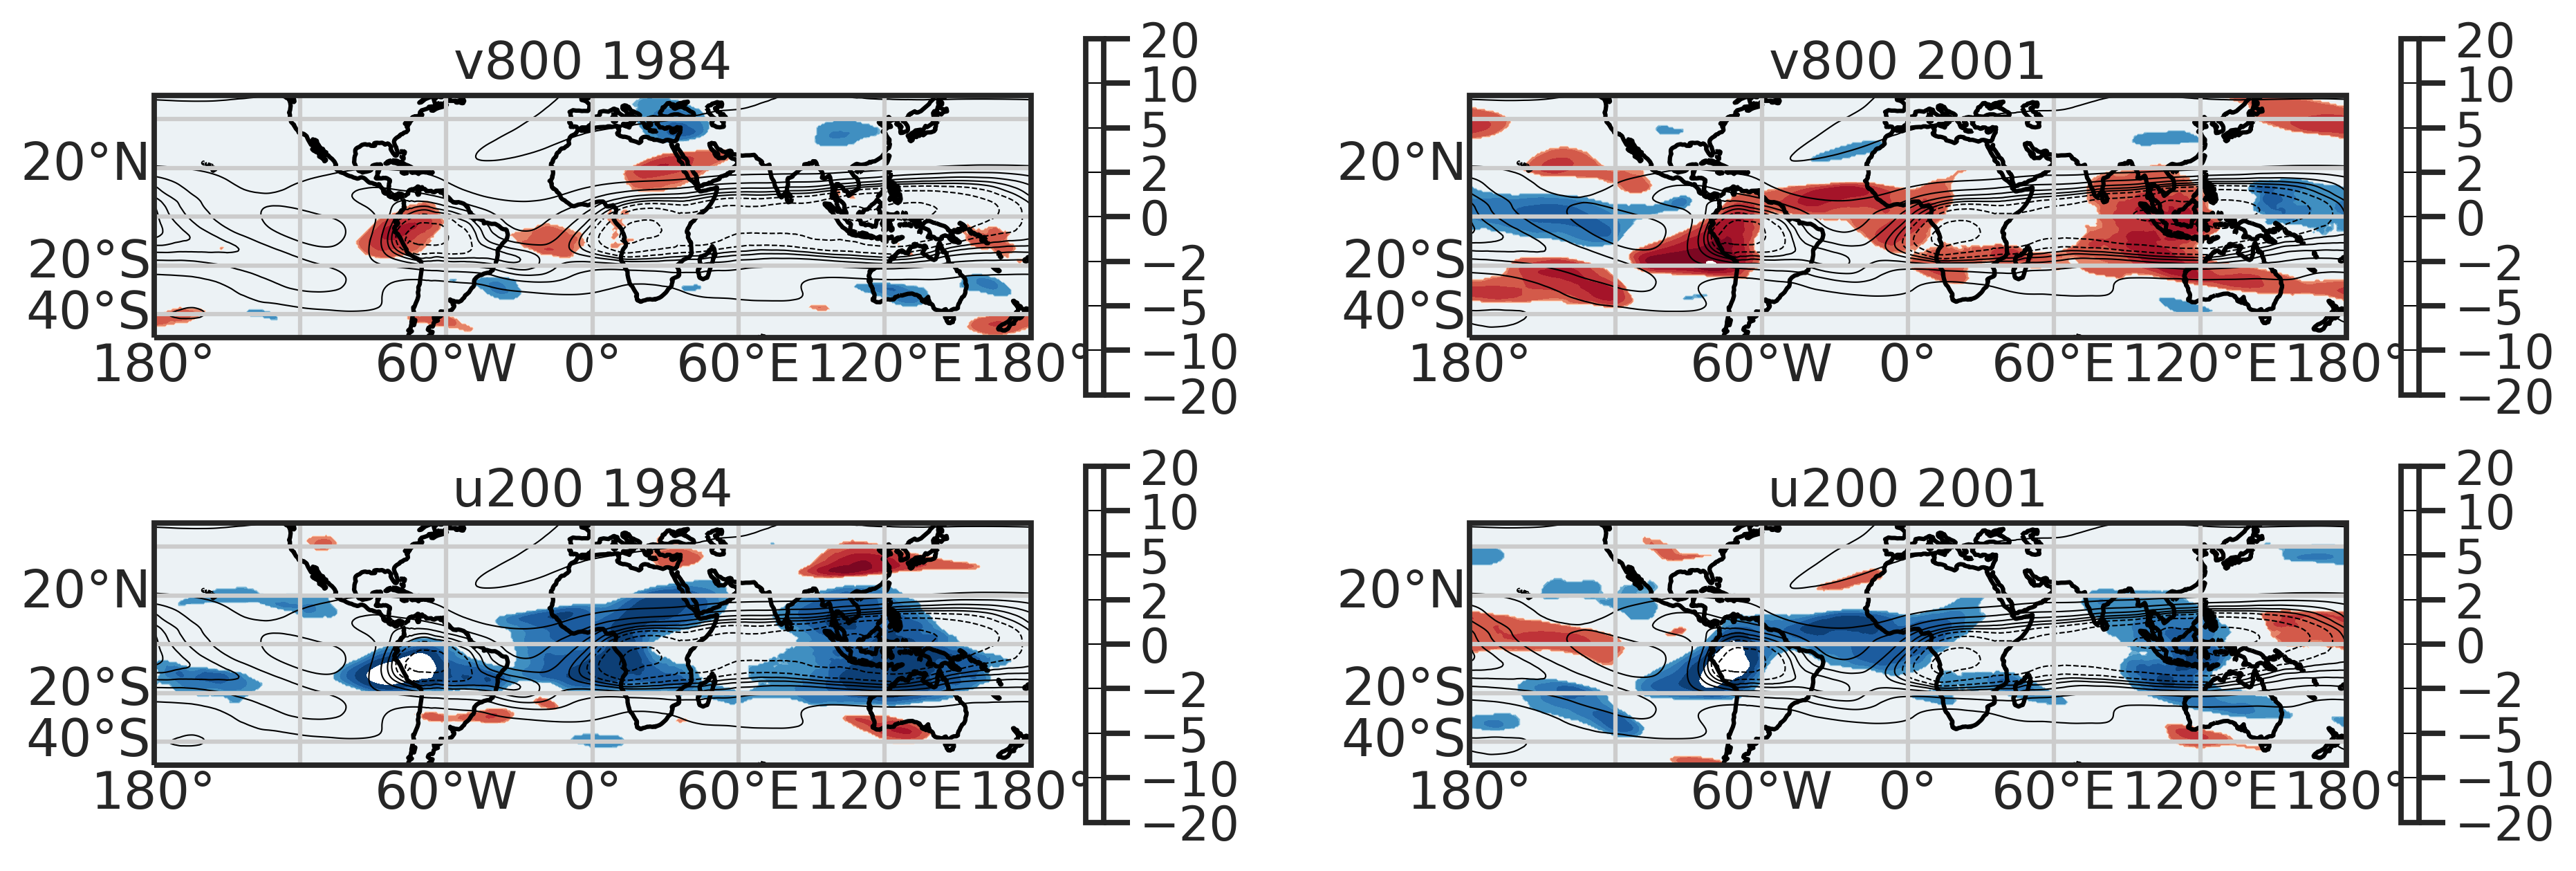

In [110]:
f = plt.figure(figsize=(15,5), dpi=300)
pstr = ['v800', 'v800', 'u200', 'u200']
for ind, dat in enumerate(outloops):
    ax = f.add_subplot(2,2,ind+1, projection=ccrs.PlateCarree())
    ax.coastlines()
    isy = ploops[ind]
        # Gridlines
    xl = ax.gridlines(draw_labels=True);
    xl.xlabels_top = False
    xl.ylabels_right = False
    dats = dat['r'].copy(deep=True)
    dats.values[dat['pval']>0.05] = 0
    plt.contourf(sst_season.longitude, sst_season.latitude, dats, levels=np.arange(-0.91,0.91,0.1), cmap='RdBu', transform=ccrs.PlateCarree())
    plt.contour(sst_season.longitude, sst_season.latitude, sst_season.isel(time=((sst_season['time.year']>=isy[1]) & (sst_season['time.year']<=isy[2]))).mean('time'), colors='k', linewidths=0.5, transform=ccrs.PlateCarree(), levels=[-20,-10,-5,-2,0,2,5,10,20])
    plt.colorbar()
    plt.title(pstr[ind]+' '+str(ploops[ind][1]))

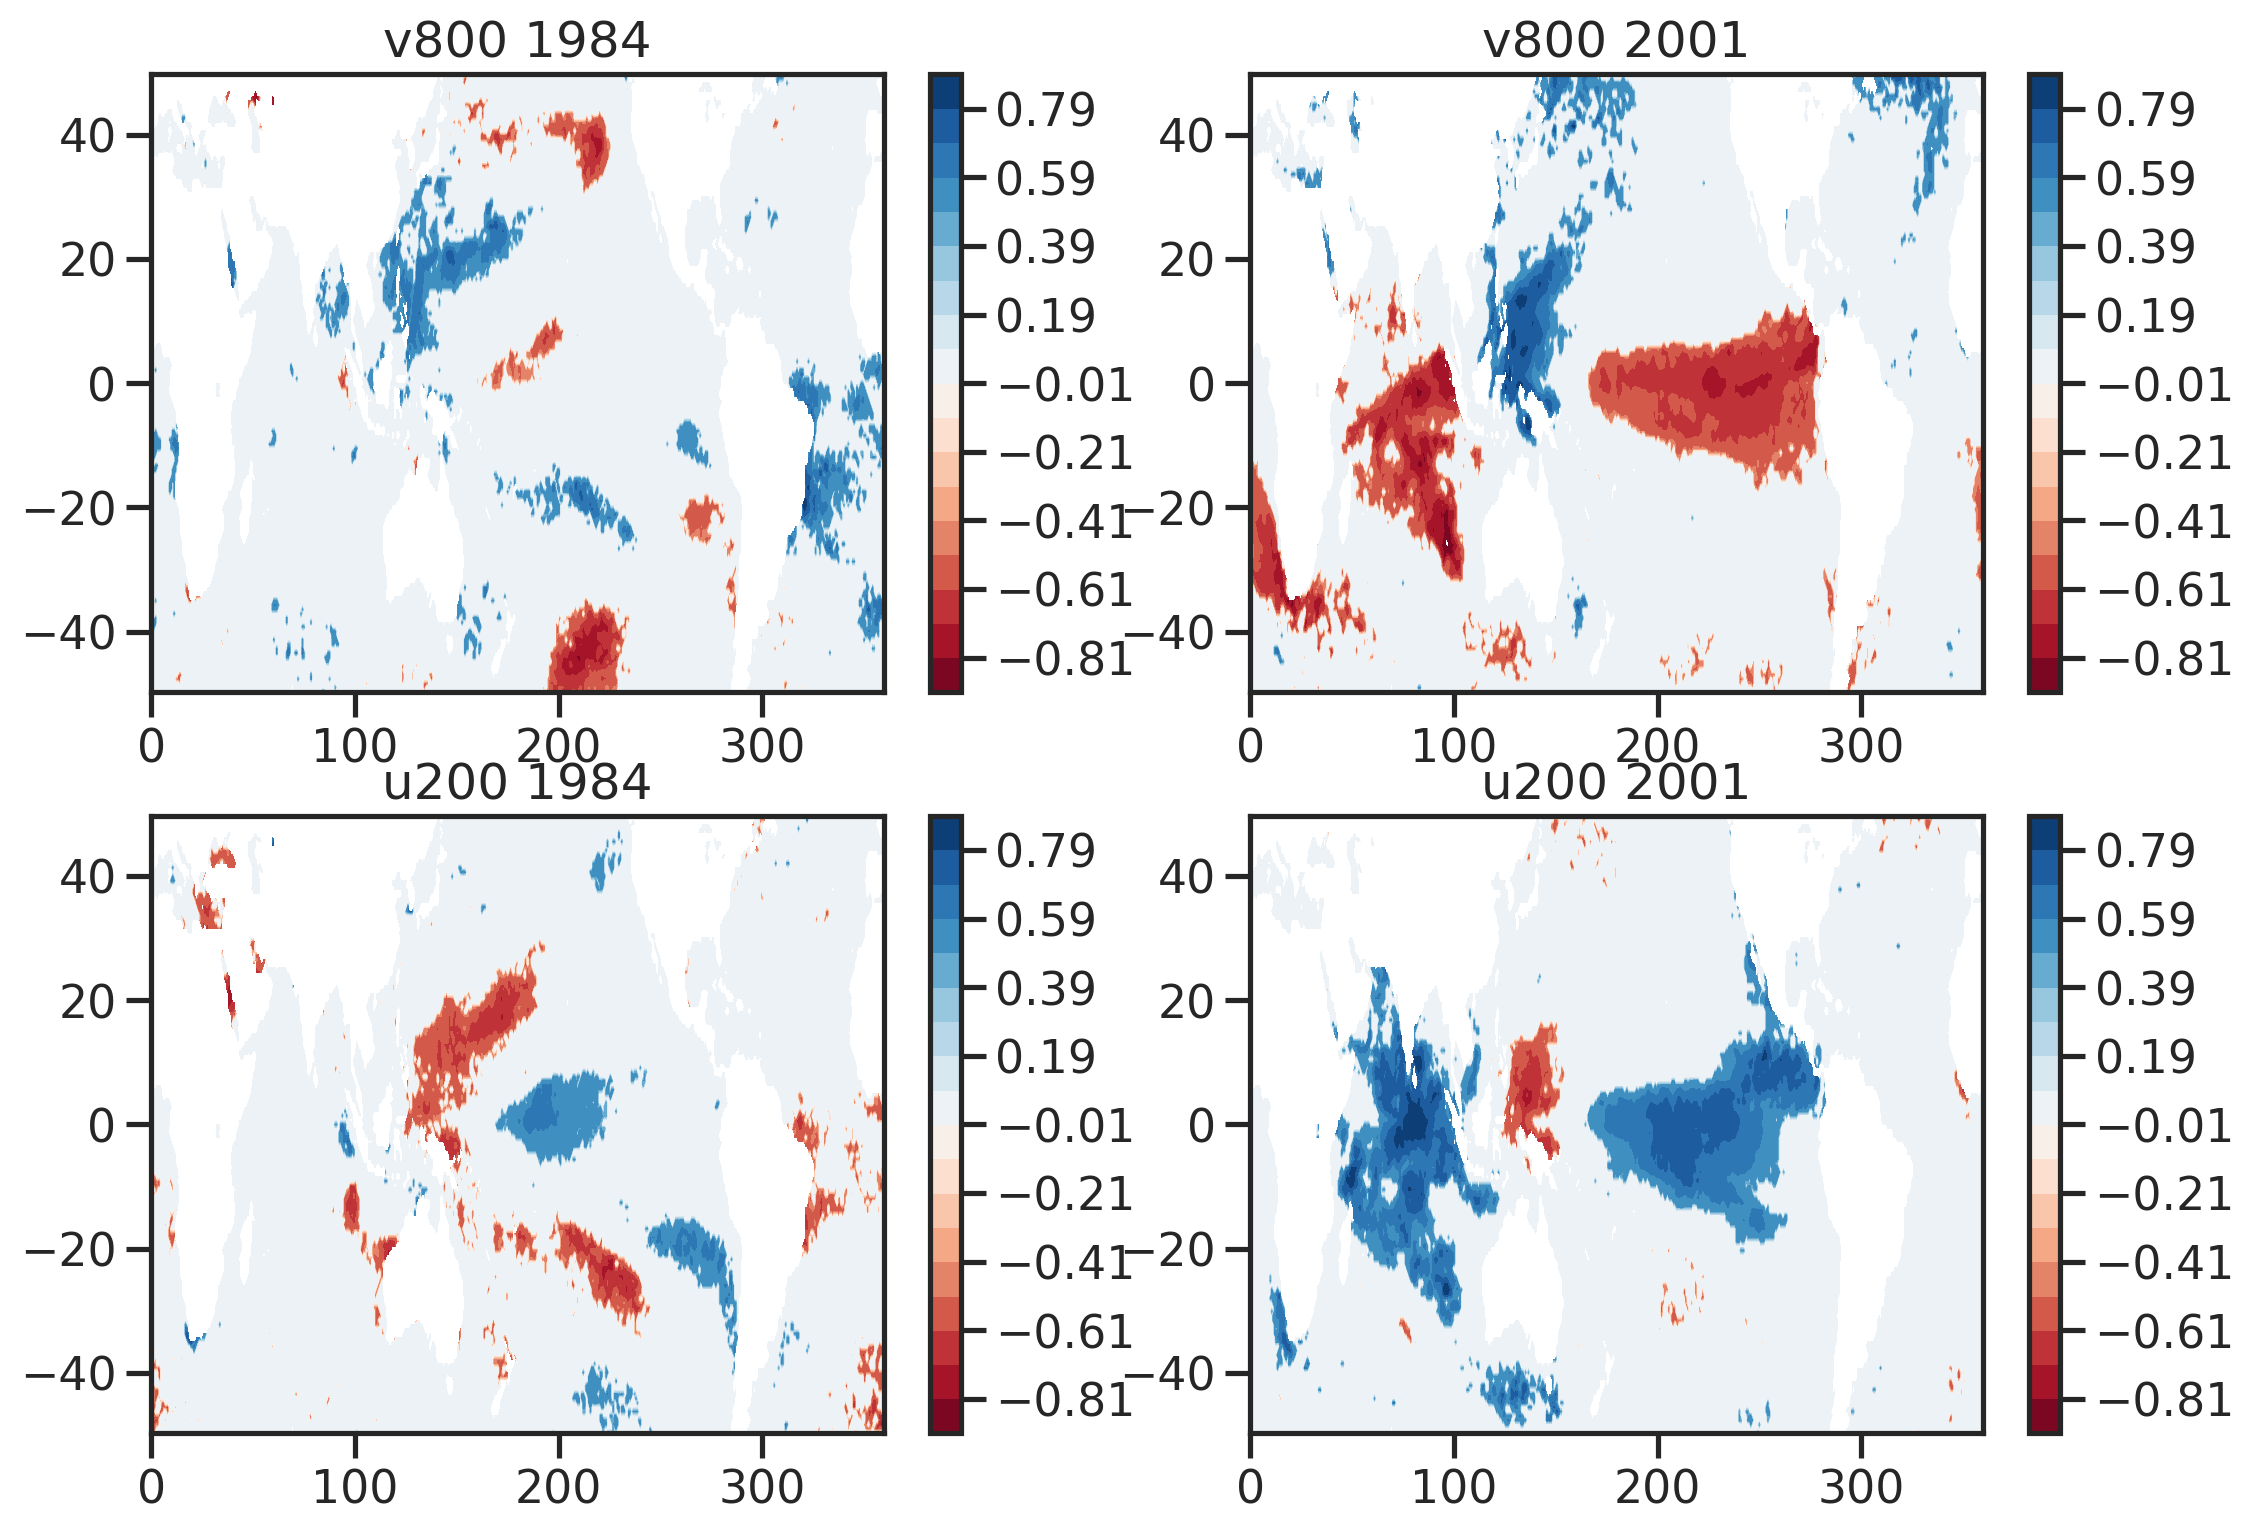

In [69]:
f = plt.figure(figsize=(13,9), dpi=200)
pstr = ['v800', 'v800', 'u200', 'u200']
for ind, dat in enumerate(outloops):
    ax = f.add_subplot(2,2,ind+1)
    dats = dat['r'].copy(deep=True)
    dats.values[dat['pval']>0.05] = 0
    plt.contourf(sst_season.longitude, sst_season.latitude, dats, levels=np.arange(-0.91,0.91,0.1), cmap='RdBu')
    plt.colorbar()
    plt.title(pstr[ind]+' '+str(ploops[ind][1]))

In [147]:
g = xr.open_mfdataset('/media/ck/Elements/SouthAmerica/ERA5/monthly/pressure_levels/synop/ERA5_monthly_pl_*.nc')
sst = uda.flip_lat(g)

In [306]:
z = sst['u'].isel(time=sst['time.hour']==15).sel(level=200).isel(expver=0)
g_season = season_mean_sst(z)
g_season = g_season.load()

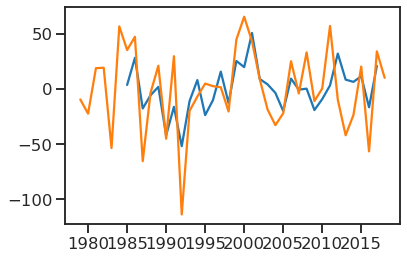

In [307]:
plt.plot(cts-np.mean(cts))
plt.plot((ets200-np.mean(ets200))*-15)

In [308]:
ploops = [(cts,1985, 1999), (cts,2000,2017), (ets200,1985,1999), (ets200,2000,2017)]
gloops = []
for pl in ploops:
    test = corr(g_season.isel(time=(g_season['time.year']>=pl[1]) & (g_season['time.year']<=pl[2])).load(), pl[0][(pl[0].index.year>=pl[1])&(pl[0].index.year<=pl[2])], bsingle=True)
    print('Did', pl[1])
    gloops.append(test)

Did 1985
Did 2000
Did 1985
Did 2000


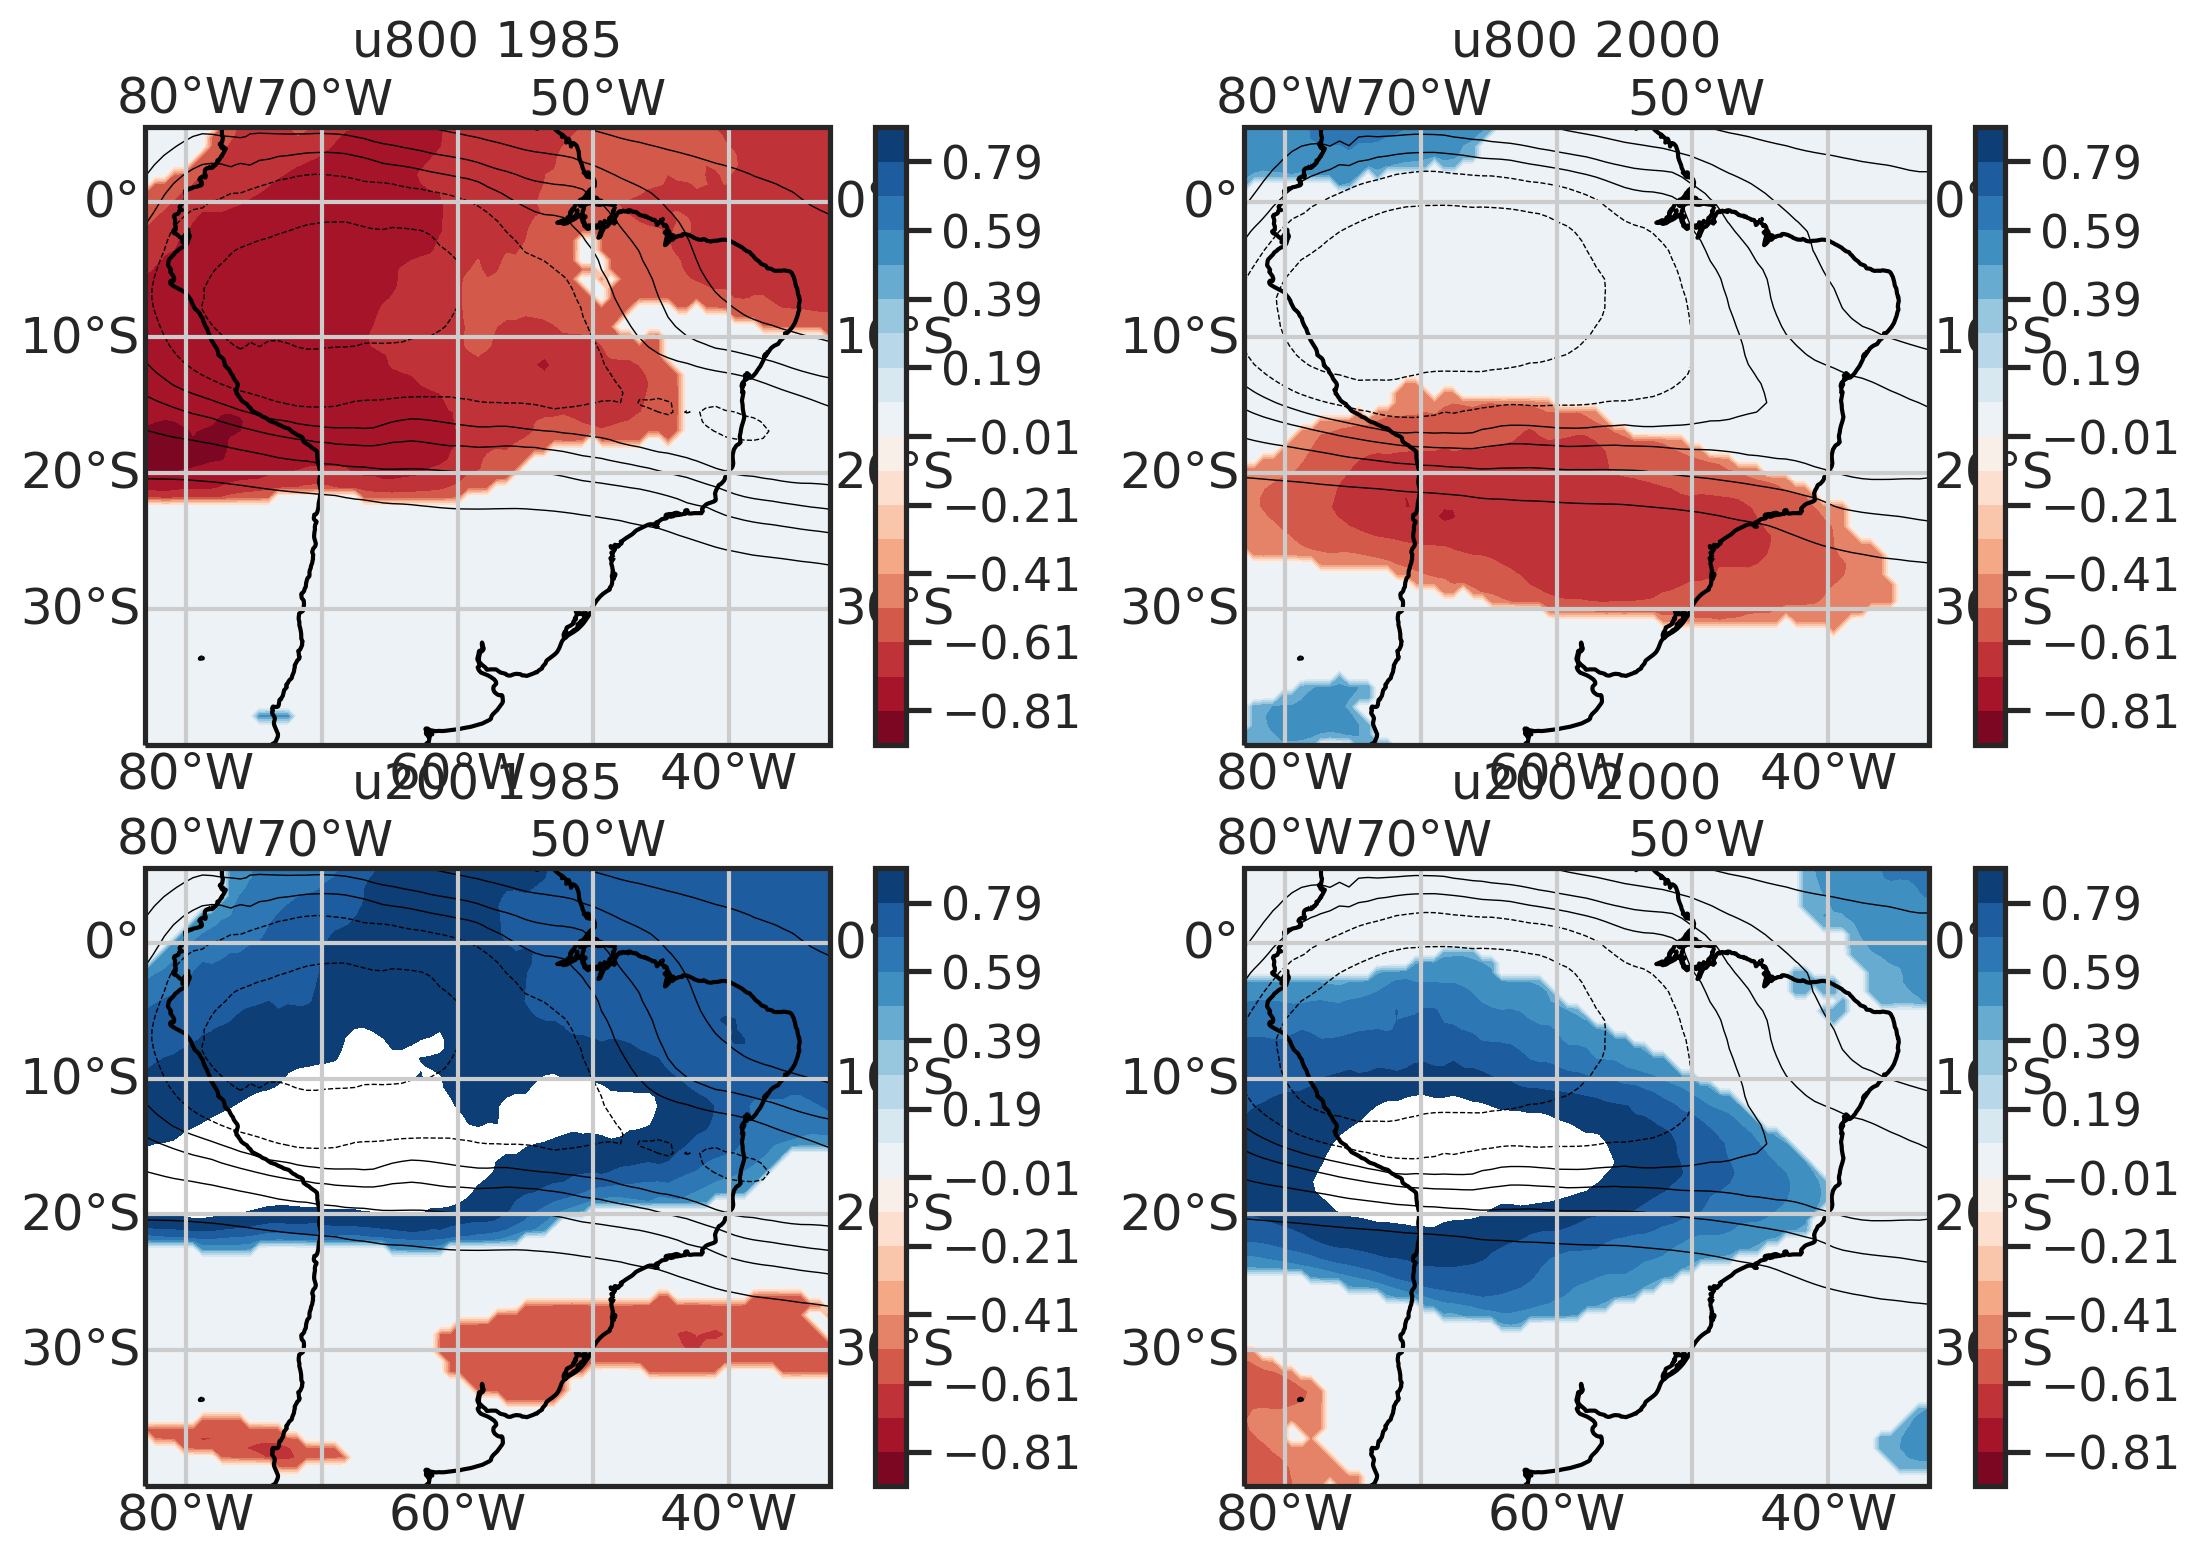

In [309]:
f = plt.figure(figsize=(13,9), dpi=200)
pstr = ['u800', 'u800', 'u200', 'u200']
for ind, dat in enumerate(gloops):
    ax = f.add_subplot(2,2,ind+1, projection=ccrs.PlateCarree())
    ax.coastlines()
    xl = ax.gridlines(draw_labels=True);
    #ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
    
    isy = ploops[ind]
    dats = dat['r'].copy(deep=True)
    dats.values[dat['pval']>0.05] = 0
    plt.contourf(sst.longitude, sst.latitude, dats, levels=np.arange(-0.91,0.91,0.1), cmap='RdBu', transform=ccrs.PlateCarree())
    plt.colorbar()
   # ipdb.set_trace()
    plt.contour(sst.longitude, sst.latitude, g_season.isel(time=((g_season['time.year']>=isy[1]) & (g_season['time.year']<=isy[2]))).mean('time'), colors='k', linewidths=0.5, transform=ccrs.PlateCarree(), levels=[-10,-5,-2,0,2,5,10])

    plt.title(pstr[ind]+' '+str(ploops[ind][1]))
#     ax = f.add_subplot(2,2,ind+1, projection=ccrs.PlateCarree())
#     ax.coastlines()
#         # Gridlines
#     xl = ax.gridlines(draw_labels=True);
#     xl.xlabels_top = False
#     xl.ylabels_right = False
#     dats = dat['r'].copy(deep=True)

#     dats.values[dat['pval']>0.05] = 0
#     plt.contourf(sst.longitude, sst.latitude, dats, levels=np.arange(-0.91,0.91,0.1), cmap='RdBu', transform=ccrs.PlateCarree())
#     plt.colorbar()
#     plt.contour(sst.longitude, sst.latitude, g_season.mean('time')/100, colors='k', linewidths=0.5, transform=ccrs.PlateCarree(), levels=np.arange(1190,1230,2))

#     plt.title(pstr[ind]+' '+str(ploops[ind][1]))

 

In [266]:
from utils import constants as cnst, u_met
u = sst['u'].isel(time=sst['time.hour']==15).sel(level=850).isel(expver=0)
v = sst['v'].isel(time=sst['time.hour']==15).sel(level=850).isel(expver=0)

ws= u_met.u_v_to_ws_wd(u.values, v.values)
z = u.copy(deep=True)
z.name = 'ws'

z.values = ws[0]
g_season = season_mean_sst(z)
g_season = g_season.load()

In [274]:
ploops = [(ett850,1984, 2000), (ett850,2001,2017), (ets200,1984,2000), (ets200,2001,2017)]
gloops = []
for pl in ploops:
    test = corr(g_season.isel(time=(g_season['time.year']>=pl[1]) & (g_season['time.year']<=pl[2])).load(), pl[0][(pl[0].index.year>=pl[1])&(pl[0].index.year<=pl[2])], bsingle=True)
    print('Did', pl[1])
    gloops.append(test)

Did 1984
Did 2001
Did 1984
Did 2001


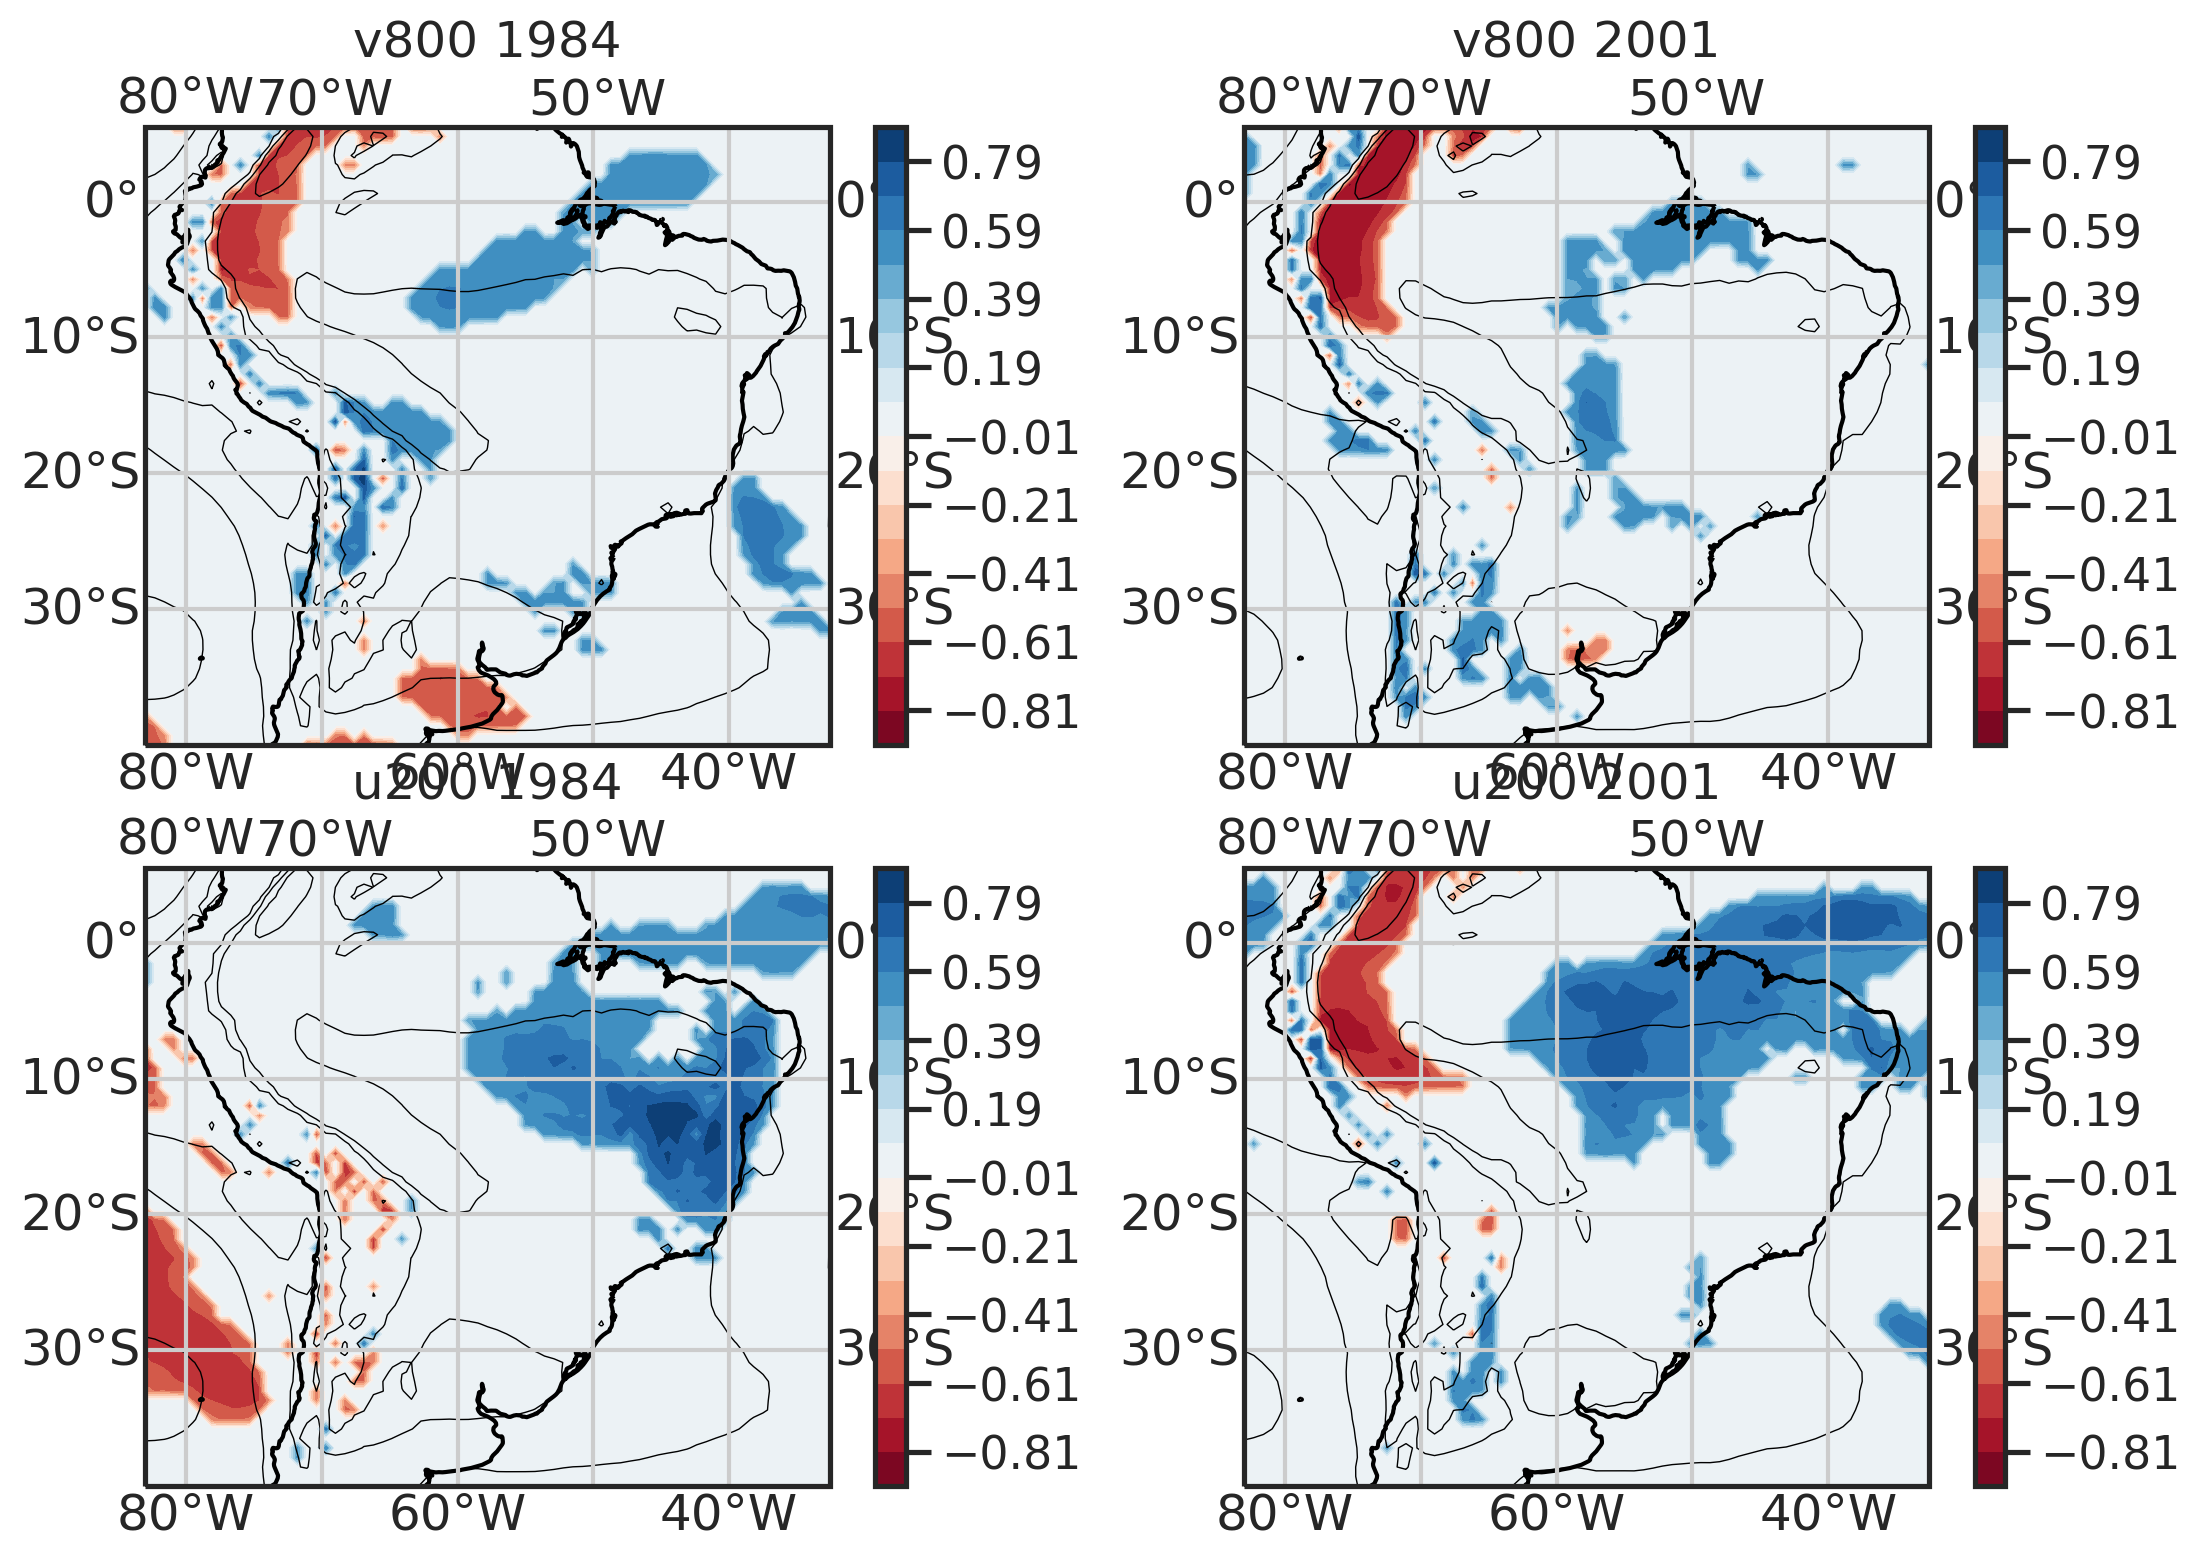

In [277]:
f = plt.figure(figsize=(13,9), dpi=200)
pstr = ['v800', 'v800', 'u200', 'u200']

for ind, dat in enumerate(gloops):
    ax = f.add_subplot(2,2,ind+1, projection=ccrs.PlateCarree())
    ax.coastlines()
    xl = ax.gridlines(draw_labels=True);
    #ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
    
    isy = ploops[ind]
    dats = dat['r'].copy(deep=True)
    dats.values[dat['pval']>0.05] = 0
    plt.contourf(sst.longitude, sst.latitude, dats, levels=np.arange(-0.91,0.91,0.1), cmap='RdBu', transform=ccrs.PlateCarree())
    plt.colorbar()
   # ipdb.set_trace()
    plt.contour(sst.longitude, sst.latitude, g_season.isel(time=((g_season['time.year']>=isy[1]) & (g_season['time.year']<=isy[2]))).mean('time'), colors='k', linewidths=0.5, transform=ccrs.PlateCarree(), levels=[-10,-5,-2,0,2,5,10])

    plt.title(pstr[ind]+' '+str(ploops[ind][1]))

In [44]:
z = sst['t'].isel(time=sst['time.hour']==15).sel(level=925).isel(expver=0)
g_season = season_mean_sst(z)
g_season = g_season.load()

In [47]:
ploops = [(etq850,1984, 2000), (etq850,2001,2017), (ets200,1984,2000), (ets200,2001,2017)]
gloops = []
for pl in ploops:
    test = corr(g_season.isel(time=(g_season['time.year']>=pl[1]) & (g_season['time.year']<=pl[2])).load(), pl[0][(pl[0].index.year>=pl[1])&(pl[0].index.year<=pl[2])], bsingle=True)
    print('Did', pl[1])
    gloops.append(test)

Did 1984
Did 2001
Did 1984
Did 2001


/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attrib

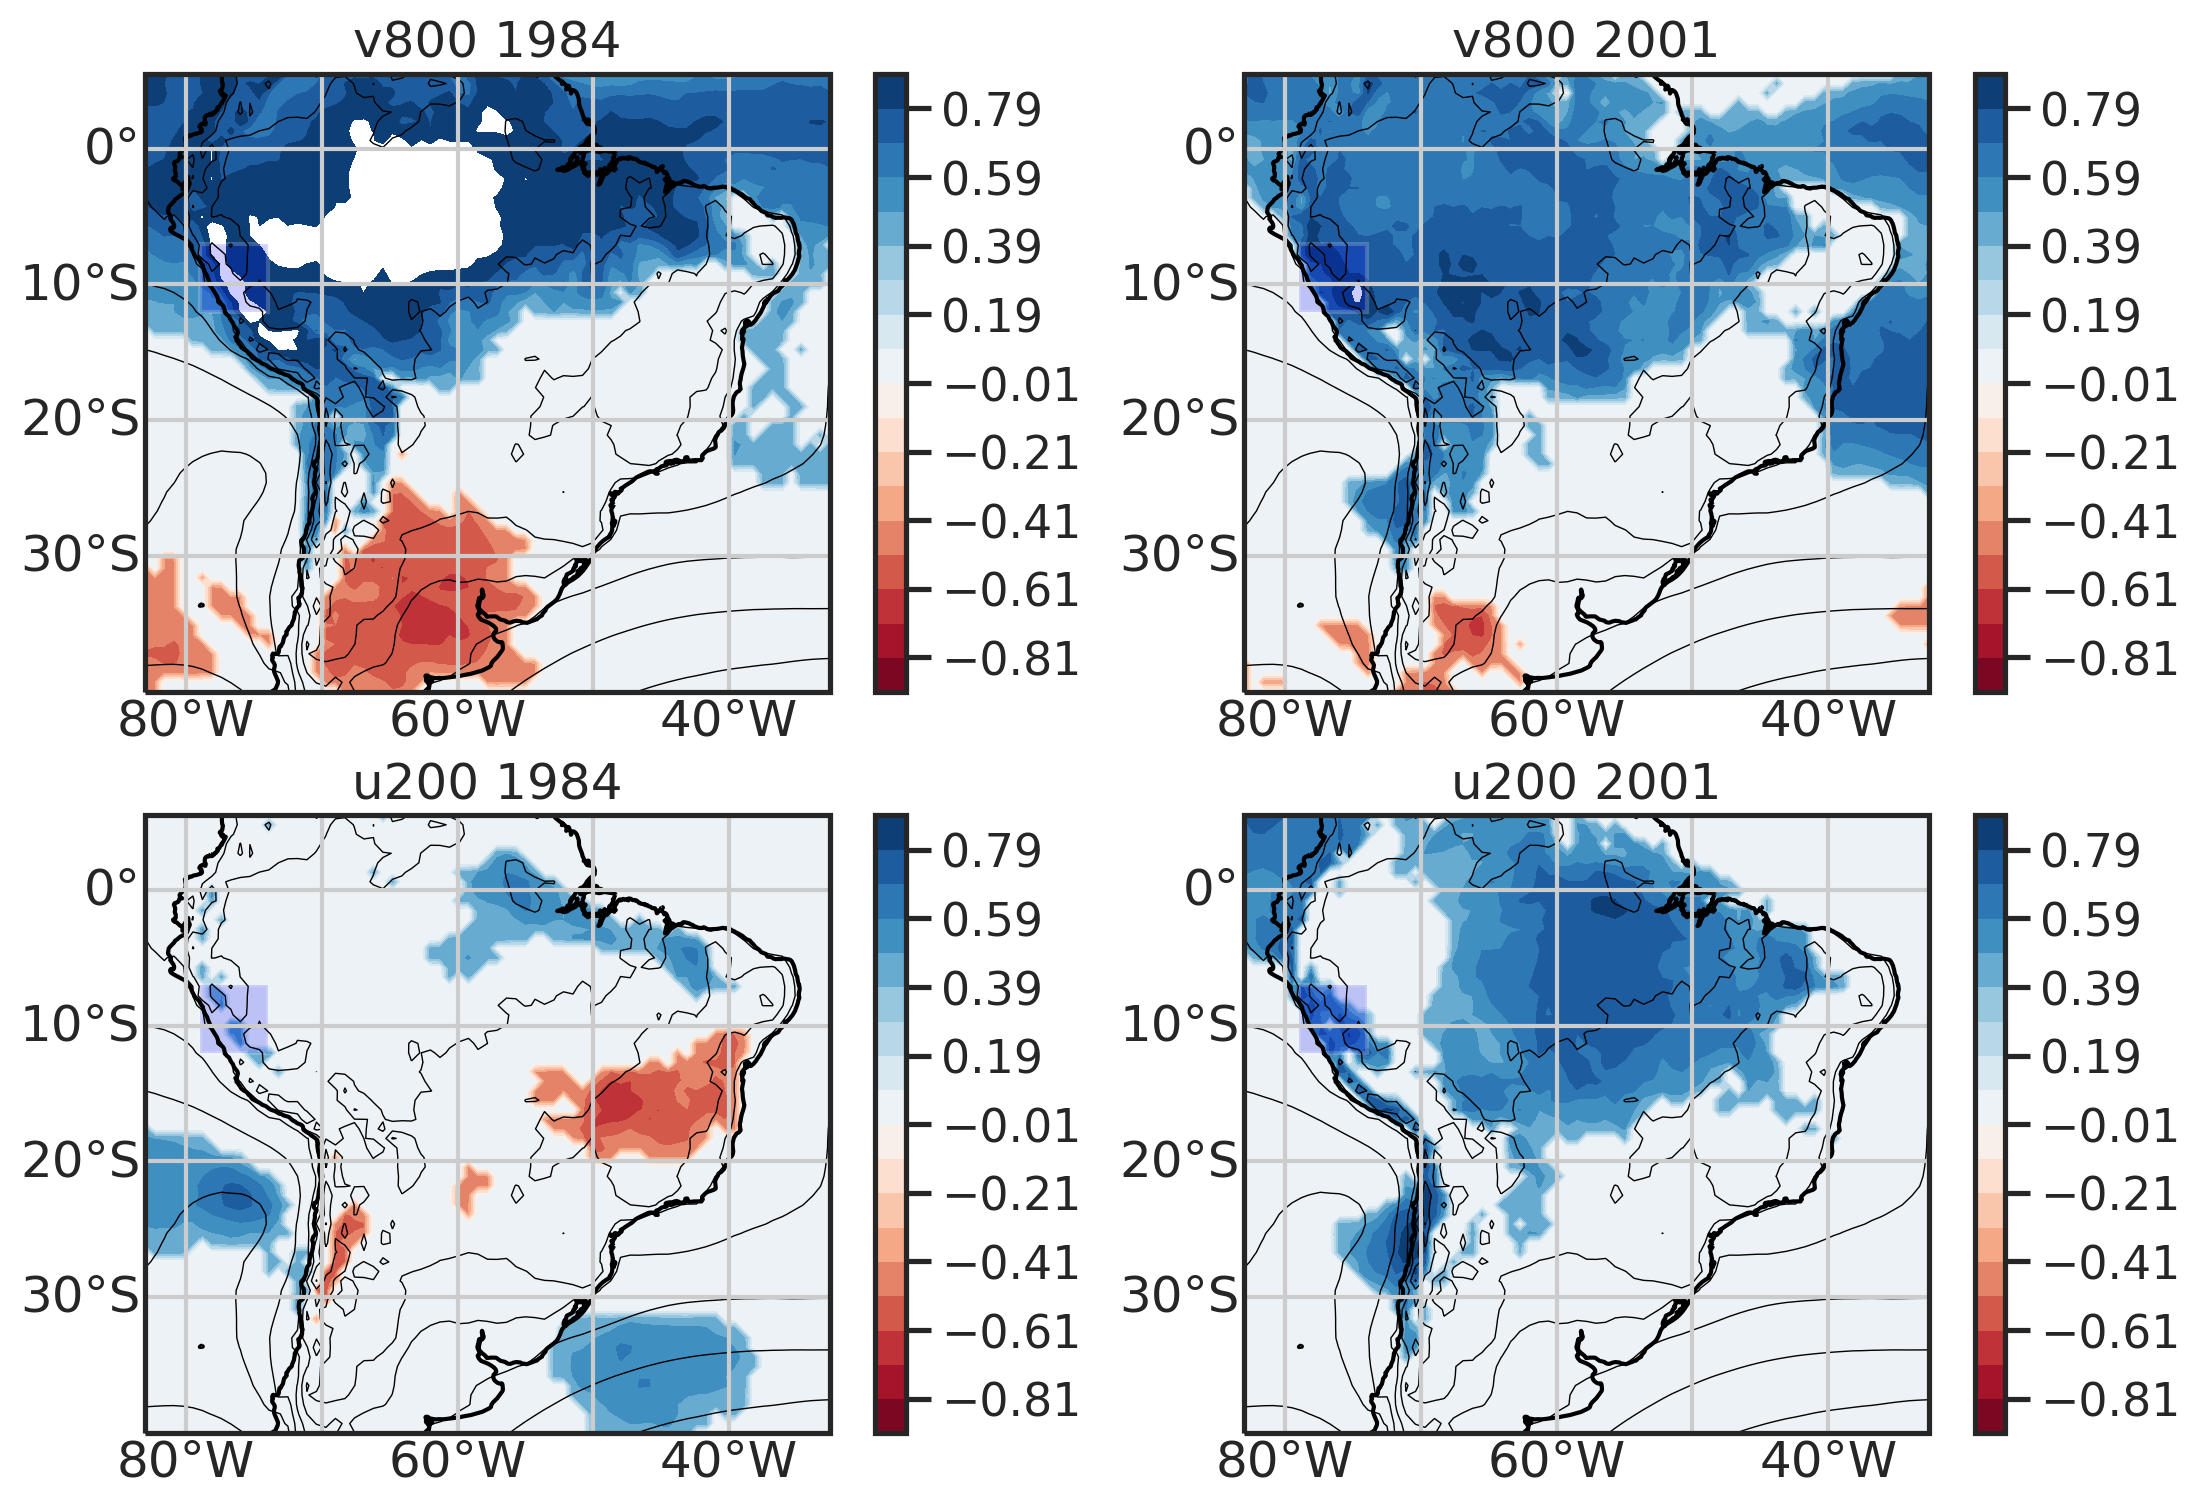

In [48]:
f = plt.figure(figsize=(13,9), dpi=200)
pstr = ['v800', 'v800', 'u200', 'u200']
for ind, dat in enumerate(gloops):
    ax = f.add_subplot(2,2,ind+1, projection=ccrs.PlateCarree())
    ax.coastlines()
        # Gridlines
    xl = ax.gridlines(draw_labels=True);
    xl.xlabels_top = False
    xl.ylabels_right = False
    dats = dat['r'].copy(deep=True)
    
    ax.add_patch(mpatches.Rectangle(xy=[peru[0], peru[2]], width=peru[1]-peru[0], height=peru[3]-peru[2],
                                    facecolor='blue',
                                    alpha=0.2,
                                    transform=ccrs.PlateCarree())
                 )
    
    dats.values[dat['pval']>0.1] = 0
    plt.contourf(sst.longitude, sst.latitude, dats, levels=np.arange(-0.91,0.91,0.1), cmap='RdBu', transform=ccrs.PlateCarree())
    plt.colorbar()
    plt.contour(sst.longitude, sst.latitude, g_season.mean('time'), colors='k', linewidths=0.5, transform=ccrs.PlateCarree()) #, levels=np.arange(-10,11,1)
    plt.title(pstr[ind]+' '+str(ploops[ind][1]))

T / q: positive correlated, constant since 1984
T / u200: positive correlated, stronger / only visible since 2001 >> 
T / v850: positive correlated along southern peruvian and Amazon belt, stable since 1984, slightly weaker / more spread out since 2001
v850 / u200: positive correlated, only strongly visible since 2001
gts in peru / sst: negatively correlated, warmer SST means less convection in peru, shows much stronger since 2001, almost non-existent pre-2001


In [90]:
z = sst['t'].isel(time=sst['time.hour']==15).sel(level=925).isel(expver=0)
g_season = season_mean_sst(z)
g_season = g_season.load()

In [91]:
ploops = [(ets,1984, 2000), (ets,2001,2017), (ets200,1984,2000), (ets200,2001,2017)]
gloops = []
for pl in ploops:
    test = corr(g_season.isel(time=(g_season['time.year']>=pl[1]) & (g_season['time.year']<=pl[2])).load(), pl[0][(pl[0].index.year>=pl[1])&(pl[0].index.year<=pl[2])], bsingle=True)
    print('Did', pl[1])
    gloops.append(test)

Did 1984
Did 2001
Did 1984
Did 2001


/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attrib

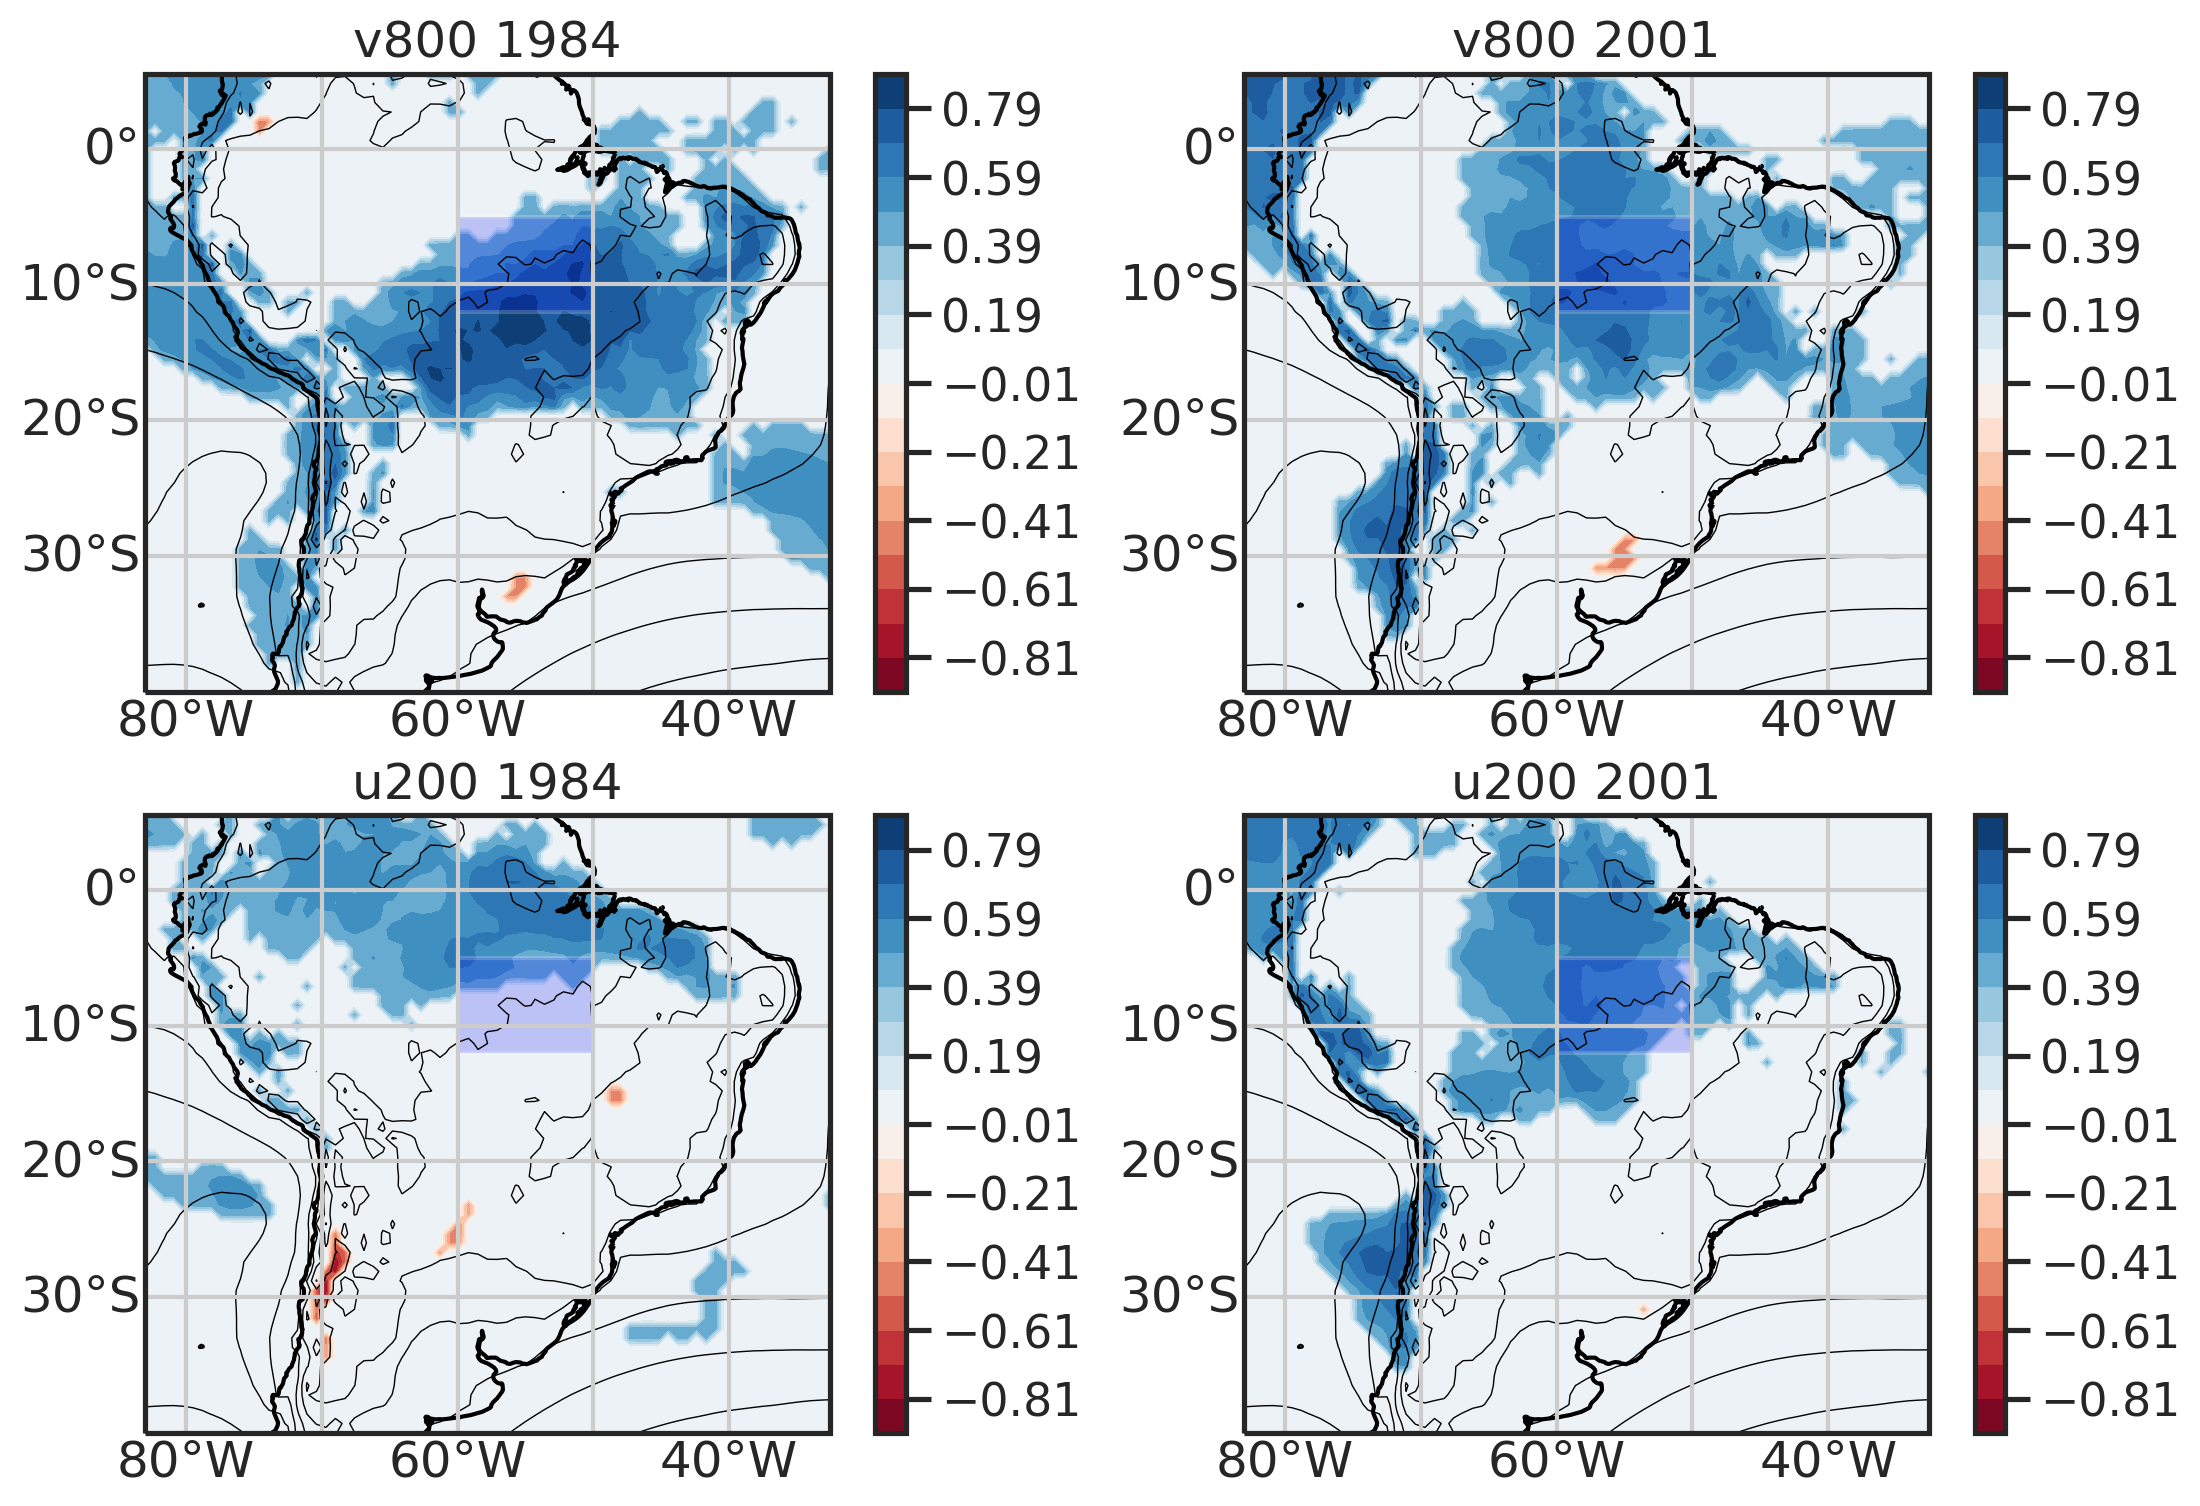

In [92]:
f = plt.figure(figsize=(13,9), dpi=200)
pstr = ['v800', 'v800', 'u200', 'u200']
for ind, dat in enumerate(gloops):
    ax = f.add_subplot(2,2,ind+1, projection=ccrs.PlateCarree())
    ax.coastlines()
        # Gridlines
    xl = ax.gridlines(draw_labels=True);
    xl.xlabels_top = False
    xl.ylabels_right = False
    dats = dat['r'].copy(deep=True)
    
    ax.add_patch(mpatches.Rectangle(xy=[tbox[0], tbox[2]], width=tbox[1]-tbox[0], height=tbox[3]-tbox[2],
                                    facecolor='blue',
                                    alpha=0.2,
                                    transform=ccrs.PlateCarree())
                 )
    
    dats.values[dat['pval']>0.1] = 0
    plt.contourf(sst.longitude, sst.latitude, dats, levels=np.arange(-0.91,0.91,0.1), cmap='RdBu', transform=ccrs.PlateCarree())
    plt.colorbar()
    plt.contour(sst.longitude, sst.latitude, g_season.mean('time'), colors='k', linewidths=0.5, transform=ccrs.PlateCarree()) #, levels=np.arange(-10,11,1)
    plt.title(pstr[ind]+' '+str(ploops[ind][1]))

In [137]:
ploops = [(gts,1984, 2000), (gts,2001,2017), (ett850,1984,2000), (ett850,2001,2017)]
outloops = []
for pl in ploops:
    test = corr(sst_season.isel(time=(sst_season['time.year']>=pl[1]) & (sst_season['time.year']<=pl[2])).load(), pl[0][(pl[0].index.year>=pl[1])&(pl[0].index.year<=pl[2])], bsingle=True)
    print('Did', pl[1])
    outloops.append(test)

/home/ck/miniconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/ck/miniconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


Did 1984


/home/ck/miniconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/ck/miniconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


Did 2001


/home/ck/miniconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/ck/miniconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


Did 1984


/home/ck/miniconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/ck/miniconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


Did 2001


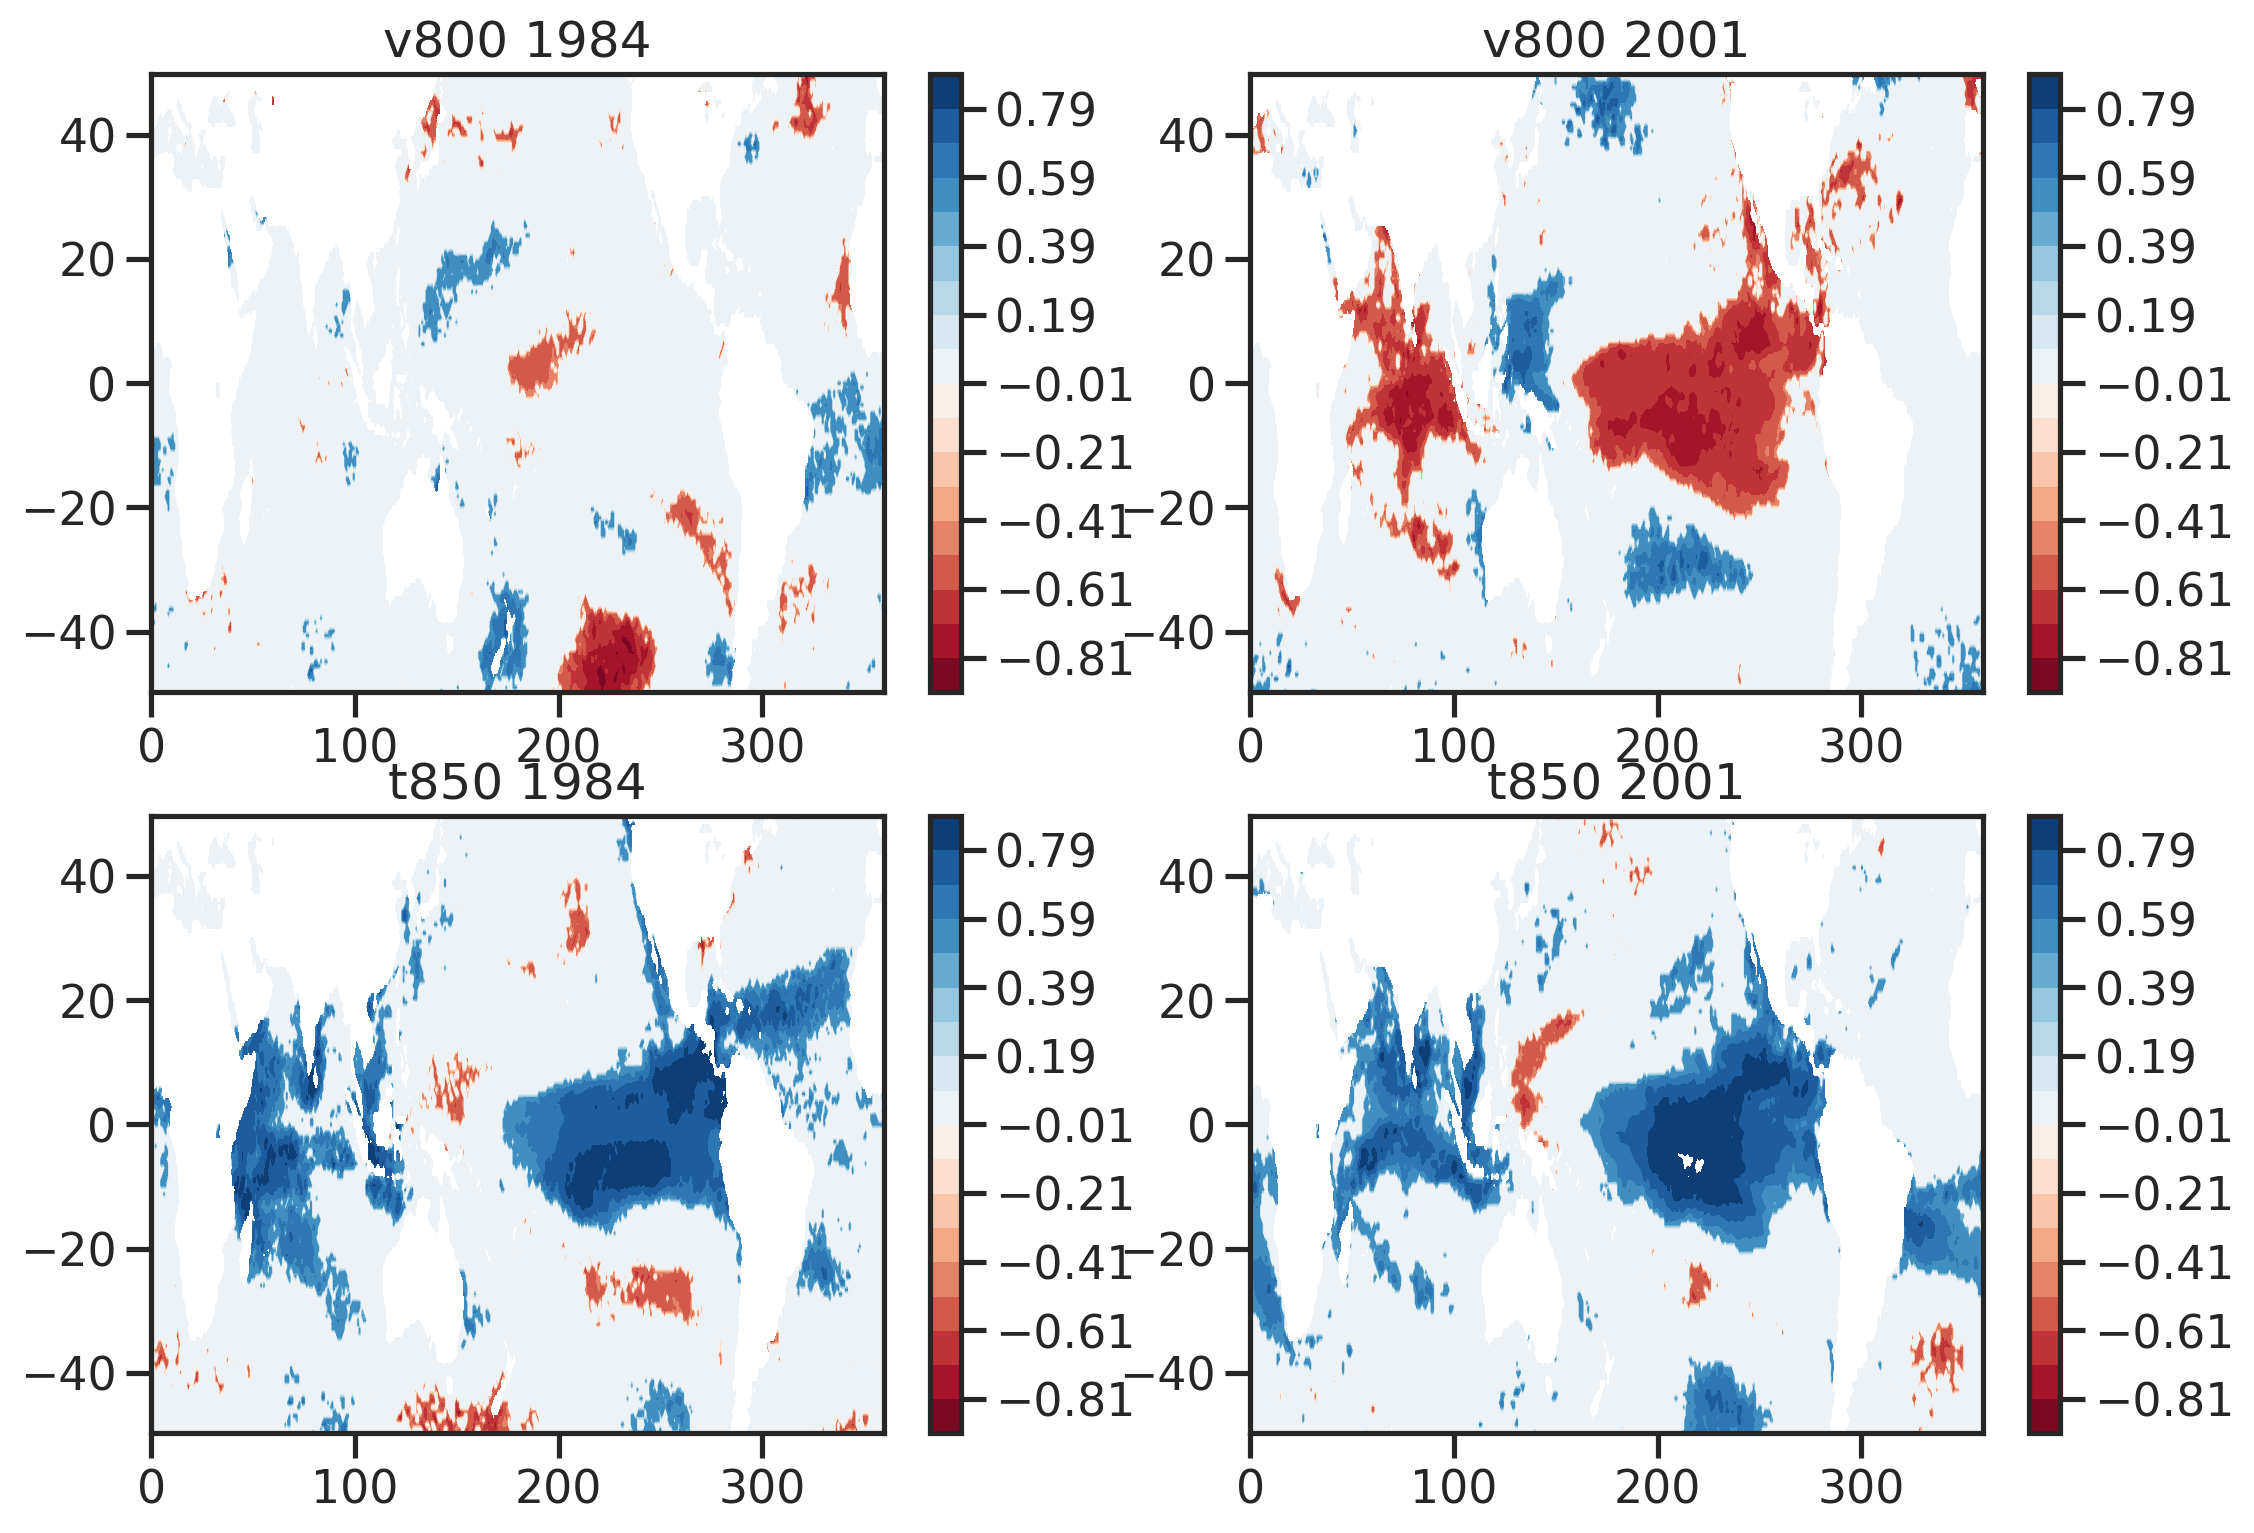

In [139]:
f = plt.figure(figsize=(13,9), dpi=200)
pstr = ['v800', 'v800', 't850', 't850']
for ind, dat in enumerate(outloops):
    ax = f.add_subplot(2,2,ind+1)
    dats = dat['r'].copy(deep=True)
    dats.values[dat['pval']>0.05] = 0
    plt.contourf(sst_season.longitude, sst_season.latitude, dats, levels=np.arange(-0.91,0.91,0.1), cmap='RdBu')
    plt.colorbar()
    plt.title(pstr[ind]+' '+str(ploops[ind][1]))